**Классификации методик лечения третьей стадии рака легких (НМИЦ профилактической медицины)**.

Денисова Елена Сергеевна, онколог.

Алексей Козлов 2023.11.15 - 2023.11.22 (11-я неделя).

# Импорт библиотек

In [3]:
# Загрузка файлов из облака
# import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
import math
import re
import os.path

# from IPython.display import clear_output
# Для работы с датами
from datetime import datetime


# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Библиотеки загружены!')

Библиотеки загружены!


# Загрузка датасета

In [4]:
#~ загрузка файла датасета lung_cancer -> рак легких
url2 = 'c:/LungCancer_AIConsultant/data_in/original_xlsx/lung_cancer_chemoradiotherapy_1.xlsx'
#~ чтение данных из файла excel в pandas.DataFrame
df1 = pd.read_excel(url2)

In [5]:
#~ размеры датафрейма и количество пропусков
print(f'размеры датафрейма df1: {df1.shape}')
print(f'  число строк: {df1.shape[0]}')
print(f'  число колонок: {df1.shape[1]}')
print('='*50)
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице (колонка цех): {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

размеры датафрейма df1: (147456, 19)
  число строк: 147456
  число колонок: 19
общее количество пропусков во всей таблице (колонка цех): 0, 0.0%


In [6]:
#~ выведем информацию о заполненности ячеек каждого признака и типе данных
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147456 entries, 0 to 147455
Data columns (total 19 columns):
 #   Column                                                    Non-Null Count   Dtype 
---  ------                                                    --------------   ----- 
 0   номер_ответа                                              147456 non-null  int64 
 1   Стадия                                                    147456 non-null  object
 2   Гистология                                                147456 non-null  object
 3   ECOG                                                      147456 non-null  object
 4   Возраст                                                   147456 non-null  object
 5   Пол                                                       147456 non-null  object
 6   Молекулярный статус (только для неплоскоклеточного рака)  147456 non-null  object
 7   PD-L1 статус                                              147456 non-null  object
 8   Статус курения

In [7]:
# Создаю список названий колонок датасета, для дальнейшего использования
df1_colnames = df1.columns.tolist()
# print(f'названия колонок: {len(df1_colnames)}: {df1_colnames}')

colnames_count = len(df1_colnames)
for i in range(colnames_count):
  i_elem = df1_colnames[i]
  print(f"{i}->{colnames_count}: '{i_elem}'")

0->19: 'номер_ответа'
1->19: 'Стадия'
2->19: 'Гистология'
3->19: 'ECOG'
4->19: 'Возраст'
5->19: 'Пол'
6->19: 'Молекулярный статус (только для неплоскоклеточного рака)'
7->19: 'PD-L1 статус'
8->19: 'Статус курения'
9->19: 'Относительные противопоказания к ЛТ'
10->19: 'Предпочтение пациента по ответу на терапию'
11->19: 'Ответ эксперта (Лактионов)'
12->19: 'Вариант ХТ'
13->19: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
14->19: 'Поставьте галочку, если уверены на 100%'
15->19: 'Если 75%'
16->19: 'Если 50%'
17->19: 'Альтернатива, если 50% - обязательно'
18->19: 'Комментарий'


# Проверка балансировки

In [8]:
def print_column_info(df, col_name):
  '''
  Функция отображение иформации по данным колонки

  Args:
    df - pandas.DataFrame
    col_name - column_name название колонки

  Returns:
    отображение иформации
  '''

  #~~~~~~~~~~~~~~~~~~~~~~~~
  print()
  print('~'*150)
  col_inx = df.columns.get_loc(col_name)

  print(f"Колонка №{col_inx}: '{col_name}'")
  print('~'*50)
  # строки с пустыми значениями
  nan_values = df[df[col_name].isnull()].index
  print(f'число строк с пустыми значениями: {len(nan_values)}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  # строки с уникальными значениями unique_values
  unique_values = df[col_name].unique().tolist()
  unique_count = len(unique_values)
  print(f'число уникальных значений: {unique_count}')
  # print(f'    {unique_values}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #создаем массив count_array из нулей по количеству уникальных значений
  count_array = np.zeros(unique_count, dtype=int)
  #val - value
  #inx - index
  #elem - element
  for elem_val in df[col_name]:
    inx = unique_values.index(elem_val)
    # print(f'elem_val: {elem_val} -> inx: {inx}')
    count_array[inx] += 1
  # count_array после подсчета значений

  #~~~~~~~~~~~~~~~~~~~~~~~~
  unique_int_labels1 = list()
  unique_str_labels2 = list()
  flag_int_labels1 = False
  for i in range(unique_count):
    print(f"  {i}: '{unique_values[i]}' -> кол-во: {count_array[i]}")
    unique_int_labels1.append(str(i))
    u_item_str = str(unique_values[i])
    unique_str_labels2.append(u_item_str)
    if len(u_item_str) > 30:
      flag_int_labels1 = True
    #~~~
    # print(f'  ->{len(u_item_str)}: `{u_item_str}`')
    # u_item_str2 = u_item_str.lower().strip()
    # print(f'  --->`{u_item_str2}`')

  # print(f'unique_int_labels1: {len(unique_int_labels1)}: {unique_int_labels1}')
  # print(f'unique_str_labels2: {len(unique_str_labels2)}: {unique_str_labels2}')

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  #~строим столбчатую гистограмму
  #~~~~~~~~~~~~~~~~~~~~~~~~
  # задаем список цветов для каждого столбика
  #          0       1      2        3         4         5         6        7       8       9       10         11
  colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

  # полотно для отображения графика
  plt.figure(figsize=(15, 7))
  # подпись графика
  plt.title(col_name)

  # отрисовка `столбиков` гистограммы
  # plot0 = sns.barplot(x=unique_values, y=count_array, palette=colors[:unique_count])
  if flag_int_labels1:
    plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)
  else:
    plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)
    # поворачиваем подписи на 45 градусов
    plt.xticks(rotation=45)

  # подписи осей
  # plt.xlabel(col_name)
  plt.ylabel("Число значений")

  # выводим значения над столбиками
  for p in plot0.patches:
    plot0.annotate(text='{}'.format(int(p.get_height())), xy=(p.get_x() + 0.05, p.get_height() + 500))

  # отображаем нарисованную гистограмму
  plt.show()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №0: 'номер_ответа'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 72
  0: '1' -> кол-во: 2048
  1: '2' -> кол-во: 2048
  2: '3' -> кол-во: 2048
  3: '4' -> кол-во: 2048
  4: '5' -> кол-во: 2048
  5: '6' -> кол-во: 2048
  6: '7' -> кол-во: 2048
  7: '8' -> кол-во: 2048
  8: '9' -> кол-во: 2048
  9: '10' -> кол-во: 2048
  10: '11' -> кол-во: 2048
  11: '12' -> кол-во: 2048
  12: '13' -> кол-во: 2048
  13: '14' -> кол-во: 2048
  14: '15' -> кол-во: 2048
  15: '16' -> кол-во: 2048
  16: '17' -> кол-во: 2048
  17: '18' -> кол-во: 2048
  18: '19' -> кол-во: 2048
  19: '20' -> кол-во: 2048
  20: '21' -> кол-во: 2048
  21: '22' -> кол-во: 2048
  22: '23' -> кол-во: 2048
  23: '24' -> кол-во: 2048
  24: '25' -> кол-во: 2048
  25: '26' -> кол-во: 2048
  26: '27' -> кол-во:

C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)
C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: UserWarning: 
The palette list has fewer values (12) than needed (72) and will cycle, which may produce an uninterpretable plot.
  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


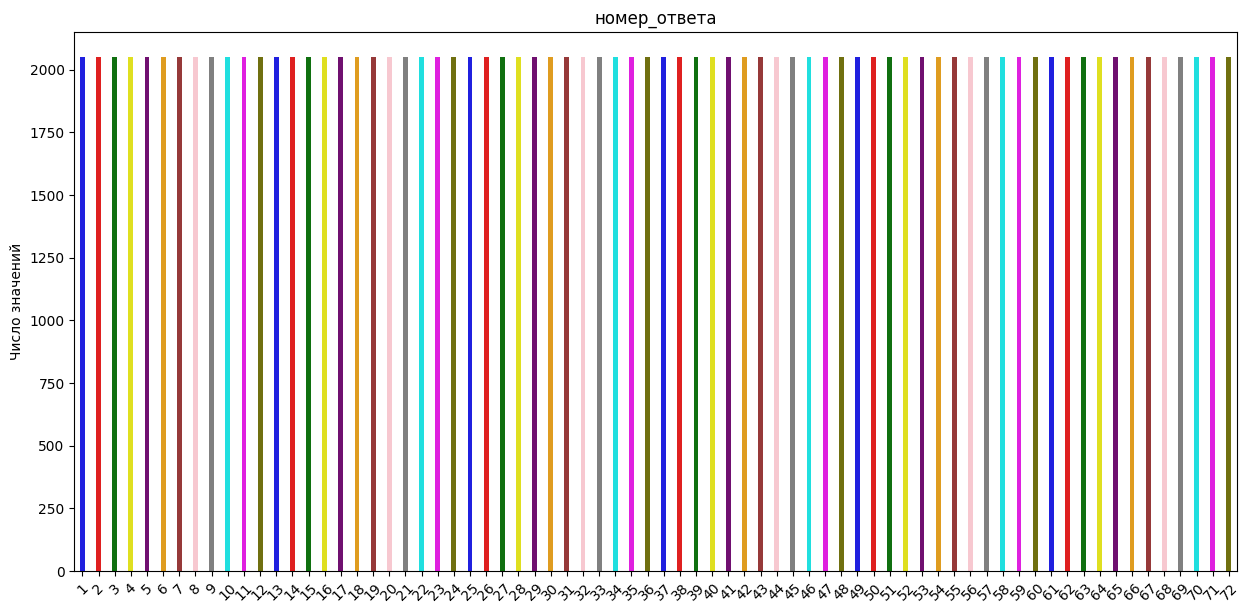


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №1: 'Стадия'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'IIIаI' -> кол-во: 73728
  1: 'IIIб' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


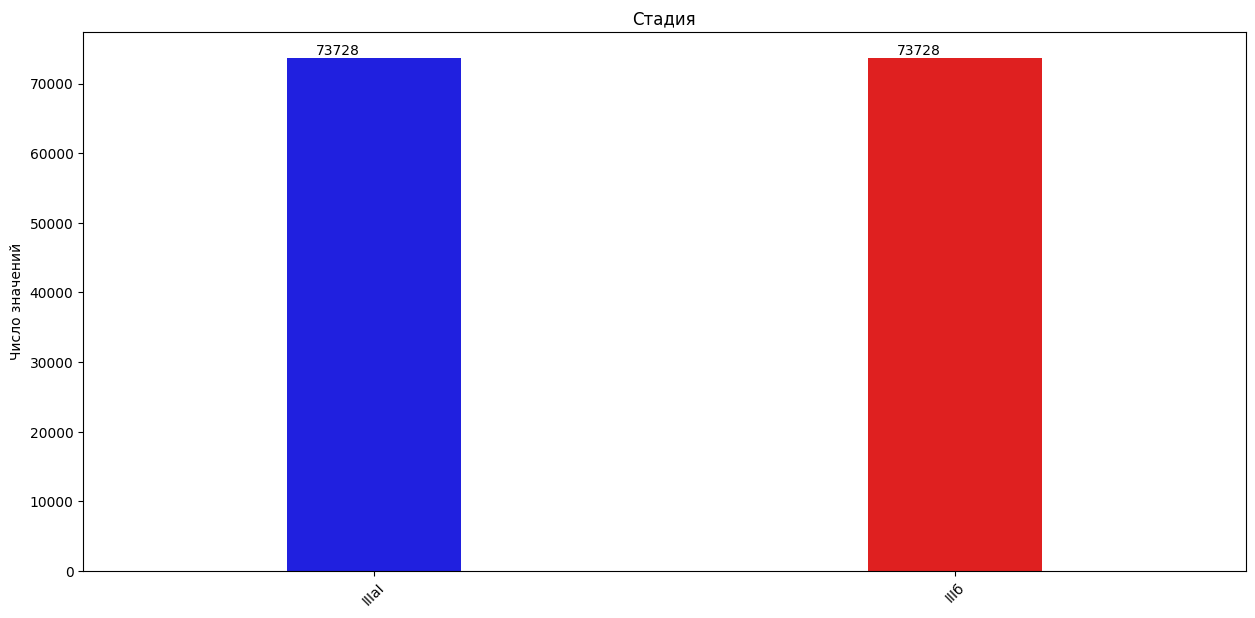

C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №2: 'Гистология'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 3
  0: ' плоскоклеточный' -> кол-во: 49152
  1: ' неплоскоклеточный' -> кол-во: 49152
  2: ' мелкоклеточный' -> кол-во: 49152


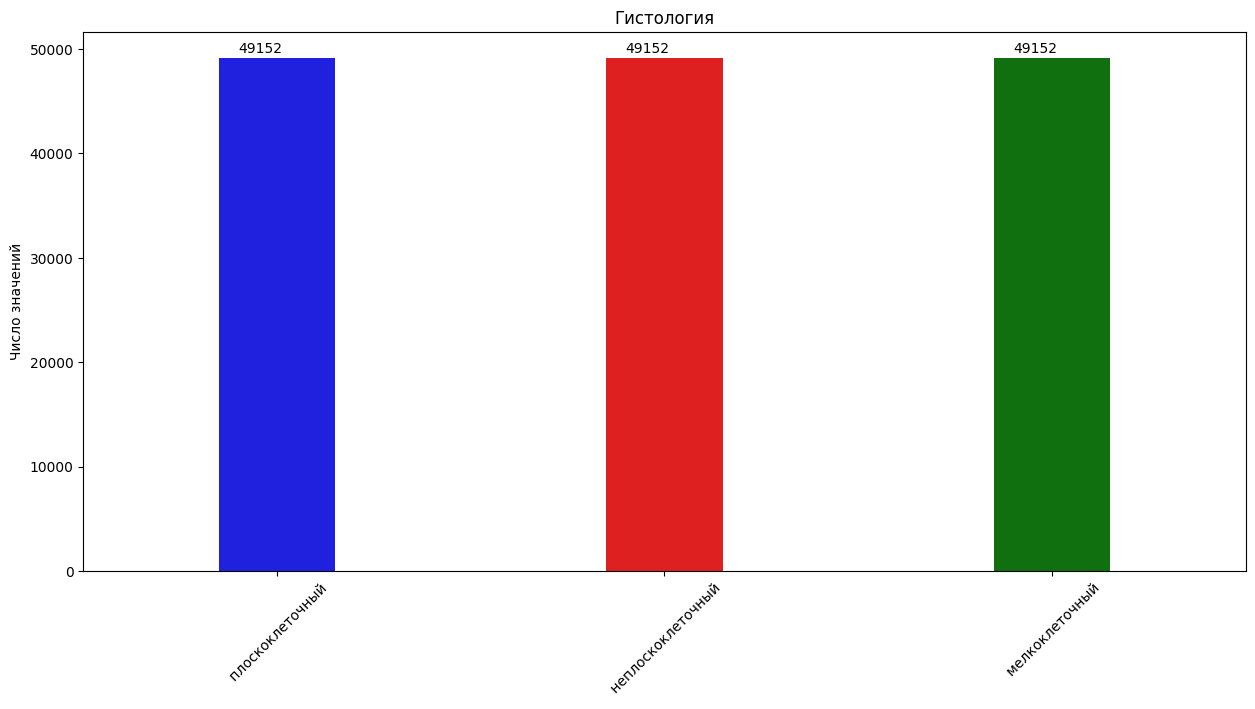


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №3: 'ECOG'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 3
  0: '  0-1' -> кол-во: 49152
  1: '2' -> кол-во: 49152
  2: ' 3+' -> кол-во: 49152


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


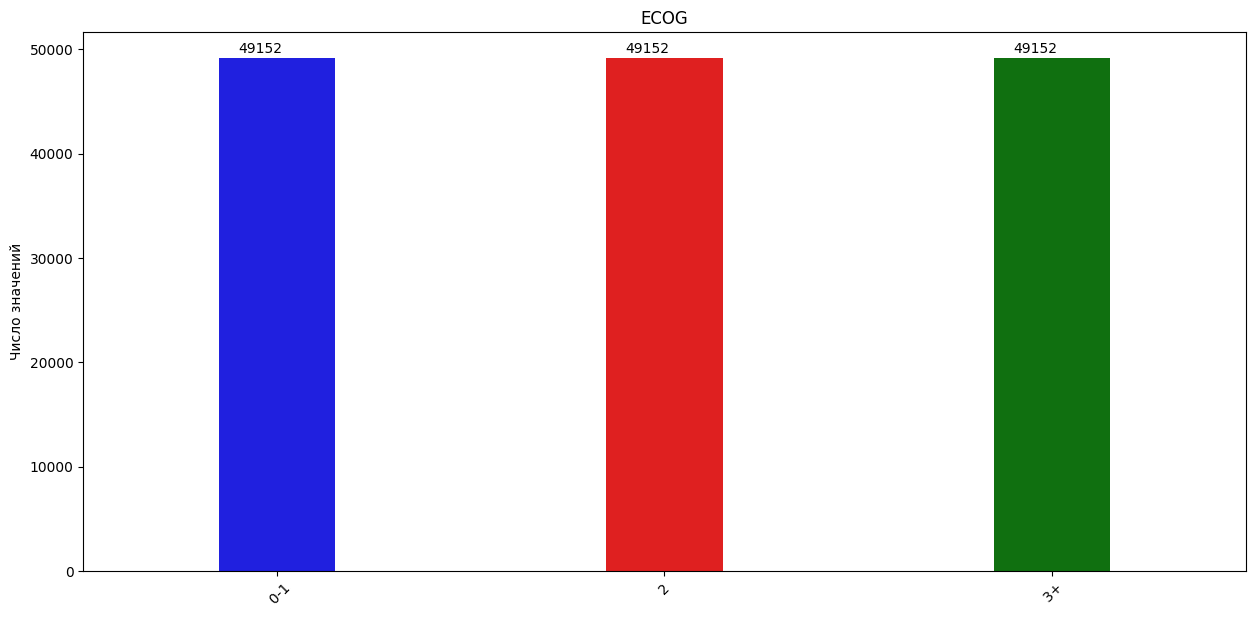


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №4: 'Возраст'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


число уникальных значений: 2
  0: ' До 70' -> кол-во: 73728
  1: ' >70' -> кол-во: 73728


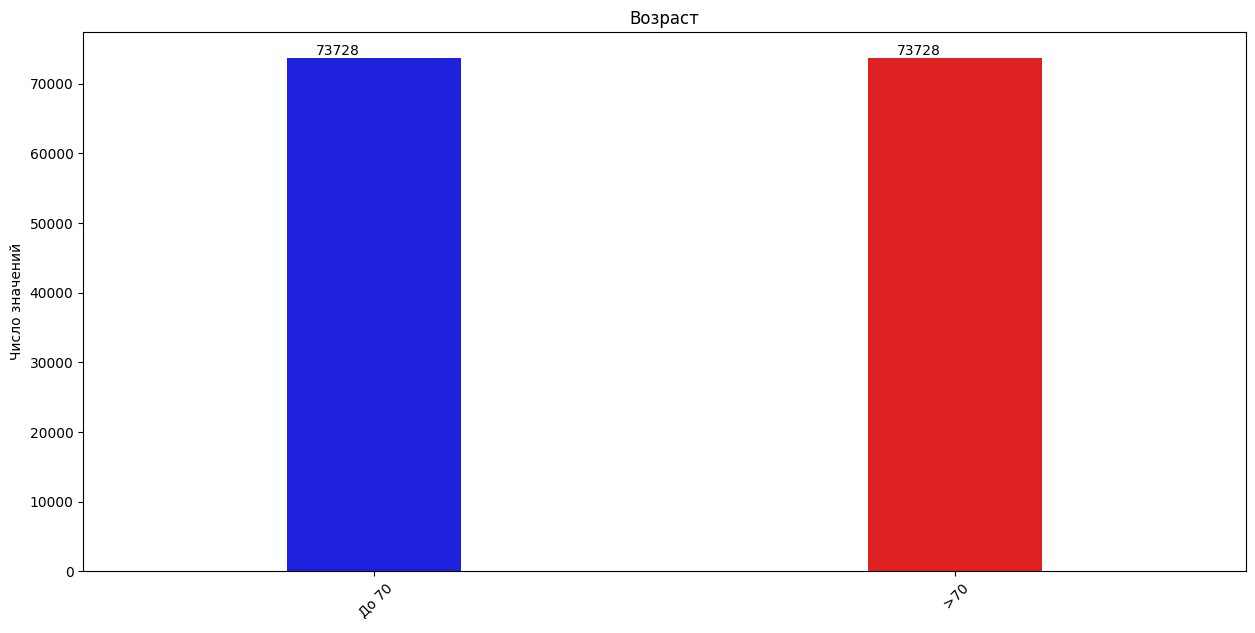

C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №5: 'Пол'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'Мужской' -> кол-во: 73728
  1: 'Женский' -> кол-во: 73728


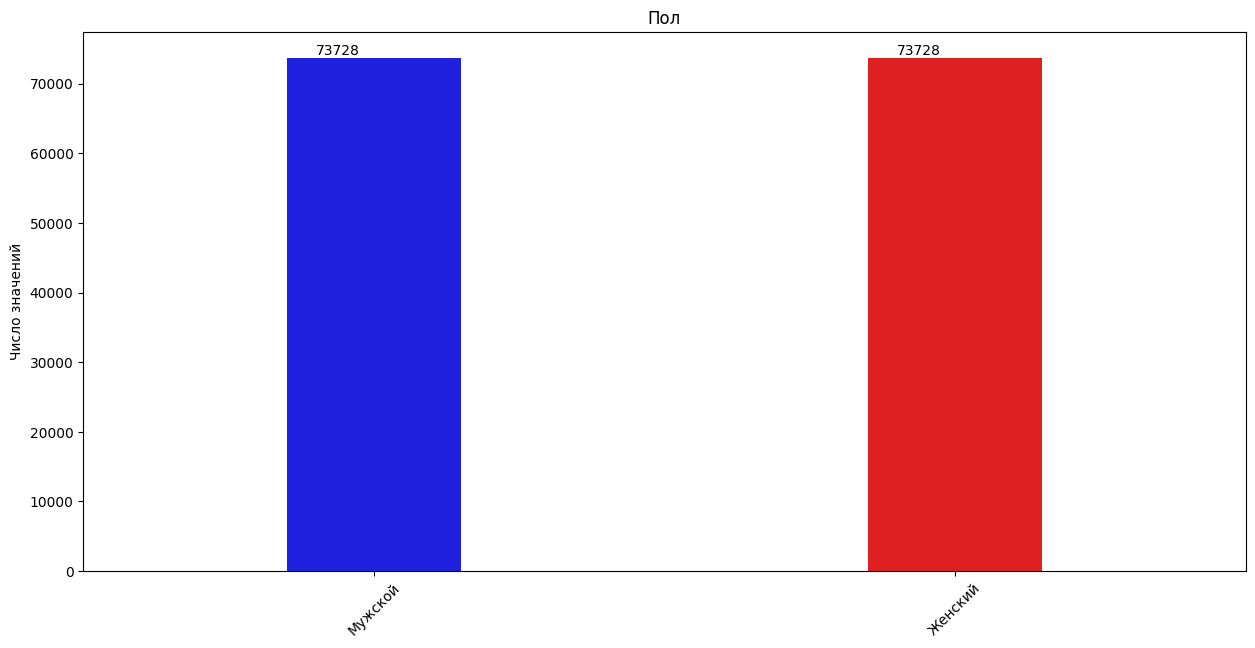


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №6: 'Молекулярный статус (только для неплоскоклеточного рака)'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 16
  0: ' нет мутаций' -> кол-во: 9216
  1: ' не исследовались' -> кол-во: 9216
  2: ' EGFR ex19' -> кол-во: 9216
  3: ' EGFR ex21' -> кол-во: 9216
  4: ' EGFR ex18' -> кол-во: 9216
  5: ' EGFR ex20' -> кол-во: 9216
  6: ' EGFR T790M' -> кол-во: 9216
  7: ' EGFR (G719X, L816Q, S768I)' -> кол-во: 9216
  8: ' ALK' -> кол-во: 9216
  9: ' ROS1' -> кол-во: 9216
  10: ' BRAF' -> кол-во: 9216
  11: ' RET' -> кол-во: 9216
  12: ' MET 14ex' -> кол-во: 9216
  13: ' HER2' -> кол-во: 9216
  14: ' KRAS G12C' -> кол-во: 9216
  15: ' NTRK' -> кол-во: 9216


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)
C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: UserWarning: 
The palette list has fewer values (12) than needed (16) and will cycle, which may produce an uninterpretable plot.
  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


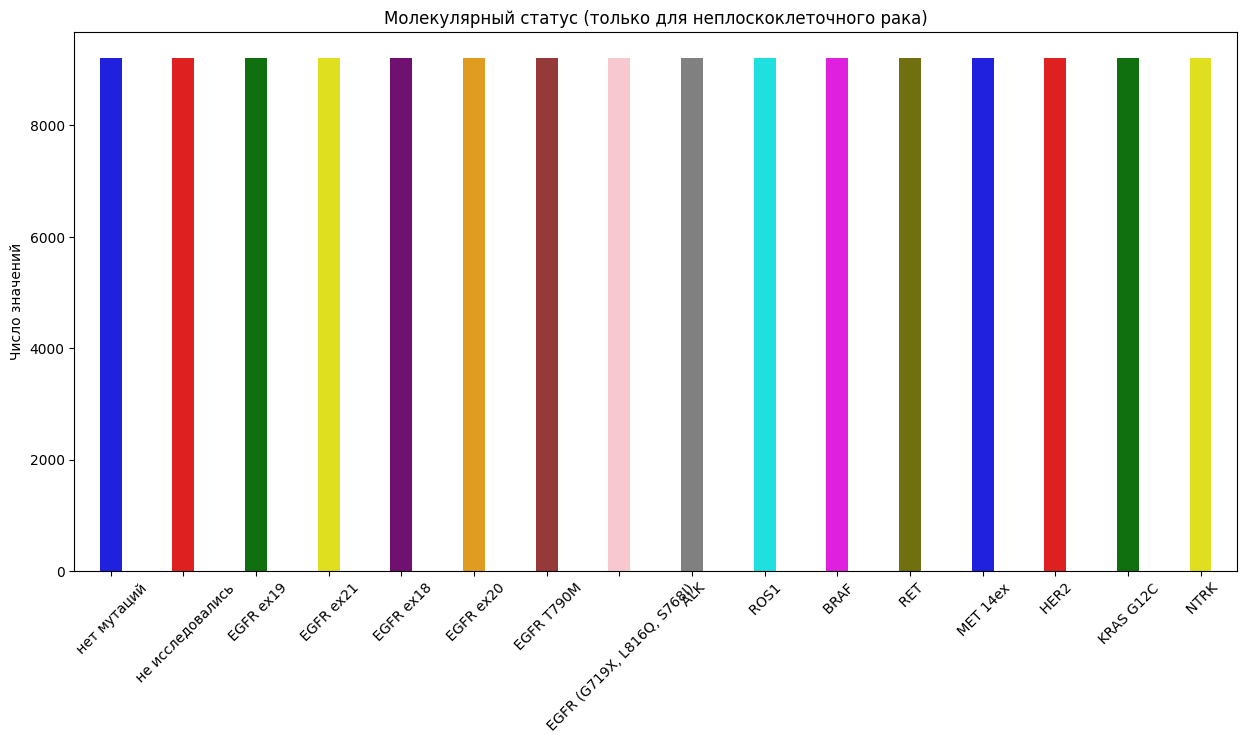


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №7: 'PD-L1 статус'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 4
  0: ' не исследовался' -> кол-во: 36864
  1: '0.01' -> кол-во: 36864
  2: ' 1–49 %' -> кол-во: 36864
  3: ' ≥50 %' -> кол-во: 36864


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


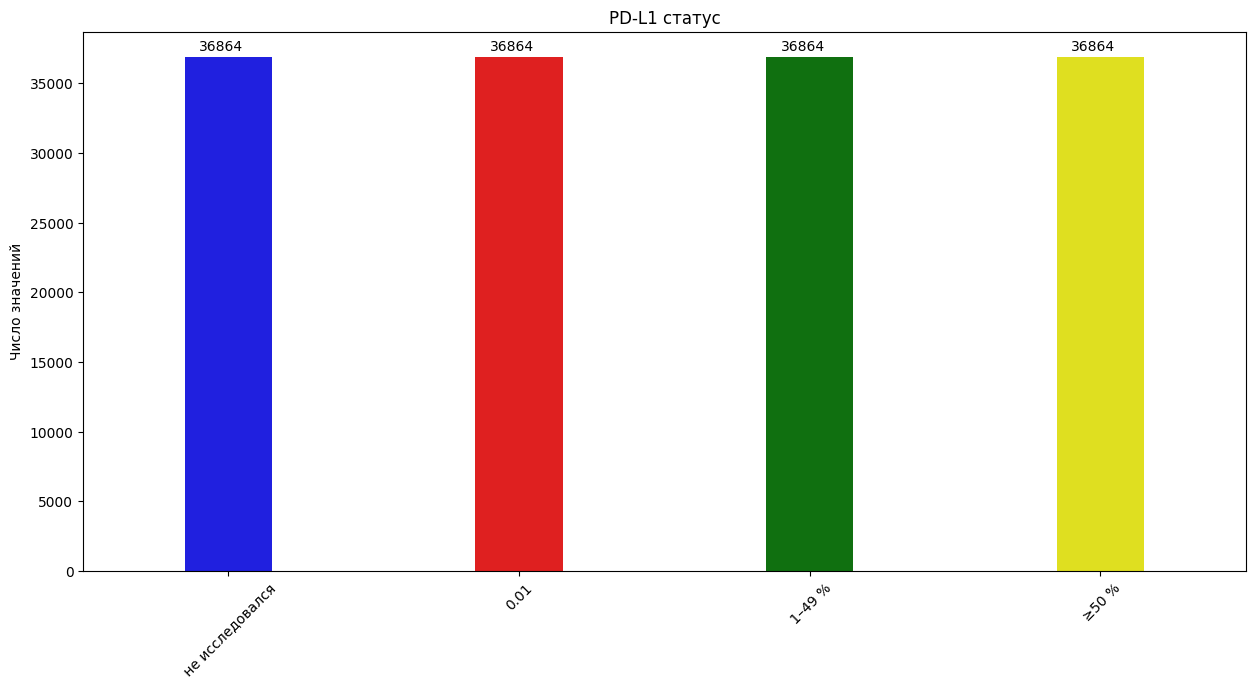


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №8: 'Статус курения'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 4
  0: ' В настоящее время' -> кол-во: 36864
  1: ' Курение в прошлом (бросил более 1 месяца до 1 года)' -> кол-во: 36864
  2: ' Курение в прошлом (бросил более 1 года)' -> кол-во: 36864
  3: ' Никогда не курил' -> кол-во: 36864


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)


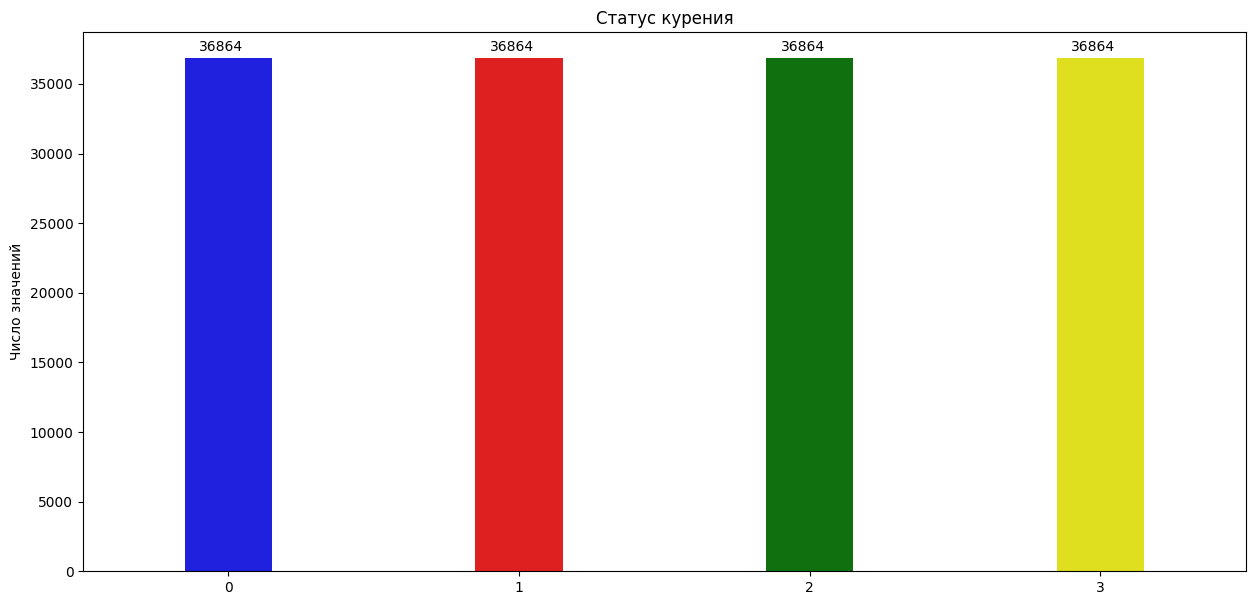

C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №9: 'Относительные противопоказания к ЛТ'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: ' да' -> кол-во: 73728
  1: ' нет' -> кол-во: 73728


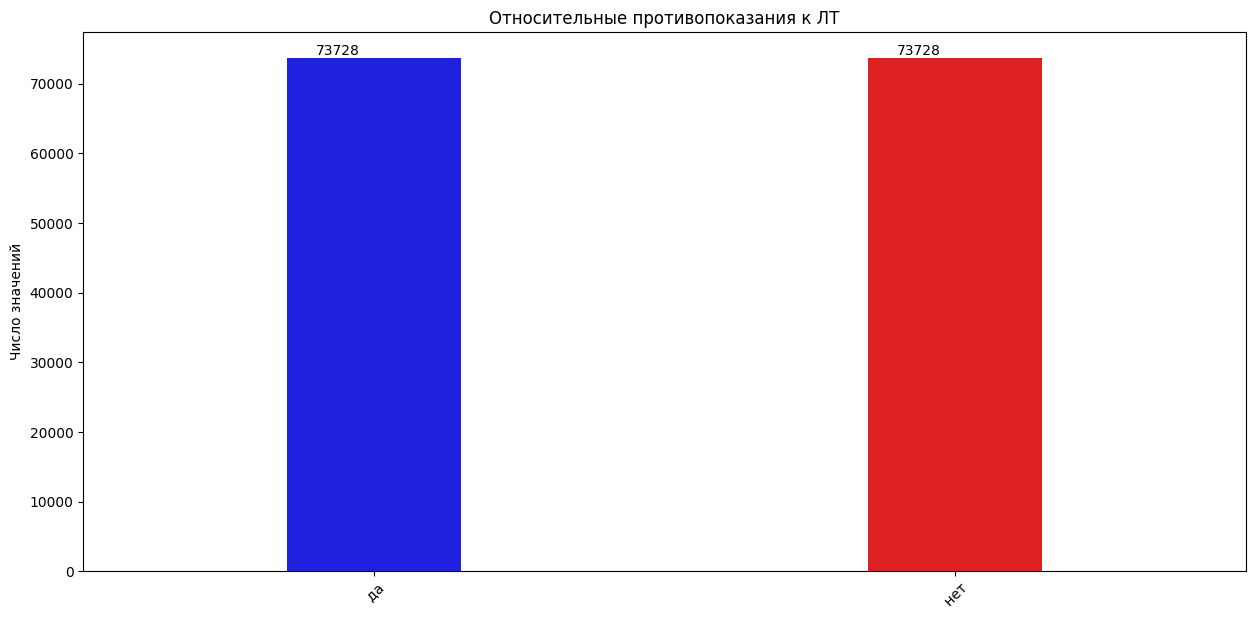


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №10: 'Предпочтение пациента по ответу на терапию'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: ' результативность лечения' -> кол-во: 73728
  1: ' сохранение качества жизни' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


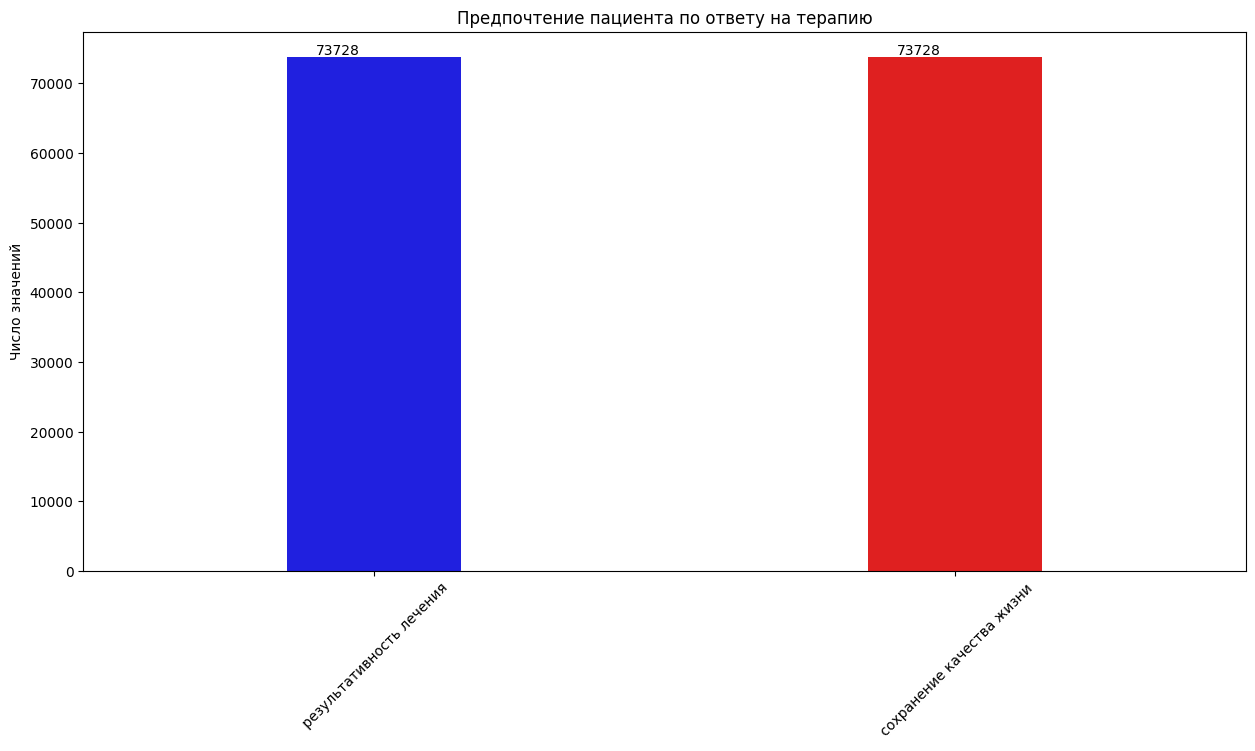


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №11: 'Ответ эксперта (Лактионов)'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 3
  0: 'одномоментная ХЛТ' -> кол-во: 53248
  1: 'последовательная ХЛТ' -> кол-во: 77824
  2: 'Симптоматическая терапия' -> кол-во: 16384


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


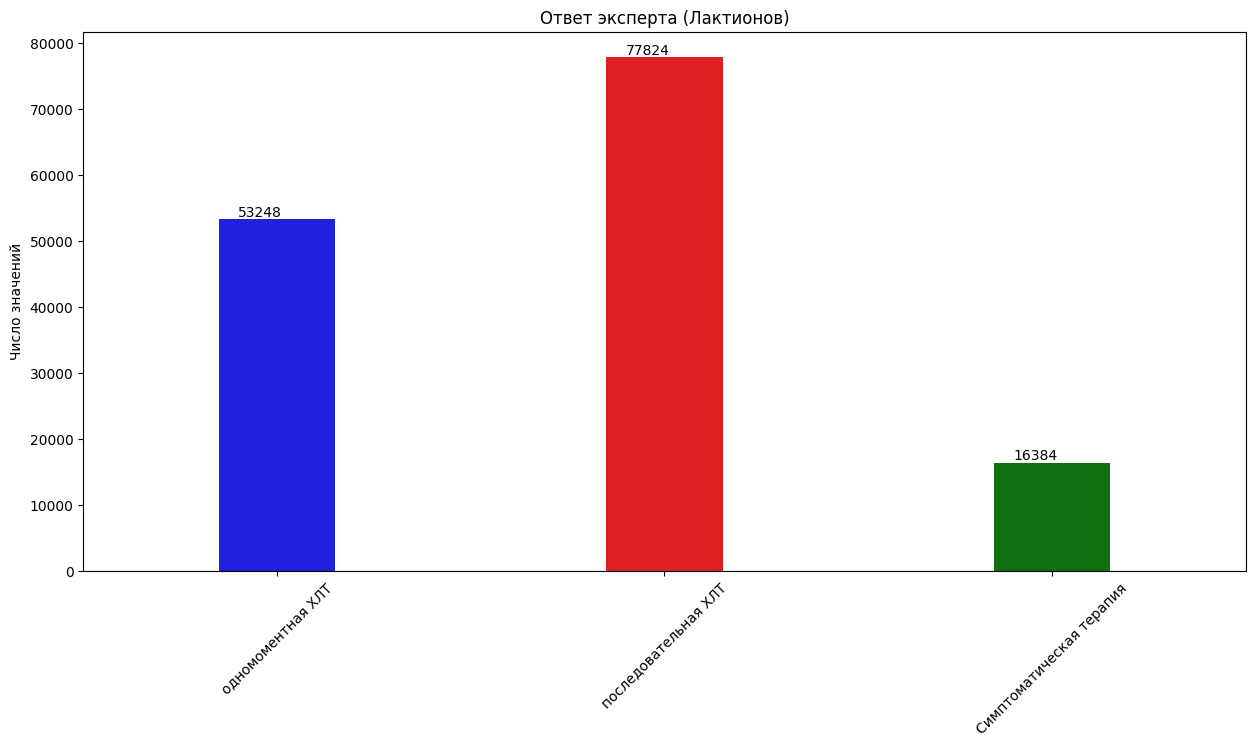


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №12: 'Вариант ХТ'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 5
  0: 'Этопозид цисплатин/карбоплатин Дурвалумаб' -> кол-во: 2048
  1: 'Этопозид цисплатин' -> кол-во: 16384
  2: 'пеметрексед+цисплатин' -> кол-во: 38912
  3: 'этопозид+цисплатин' -> кол-во: 73728
  4: '0' -> кол-во: 16384


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)


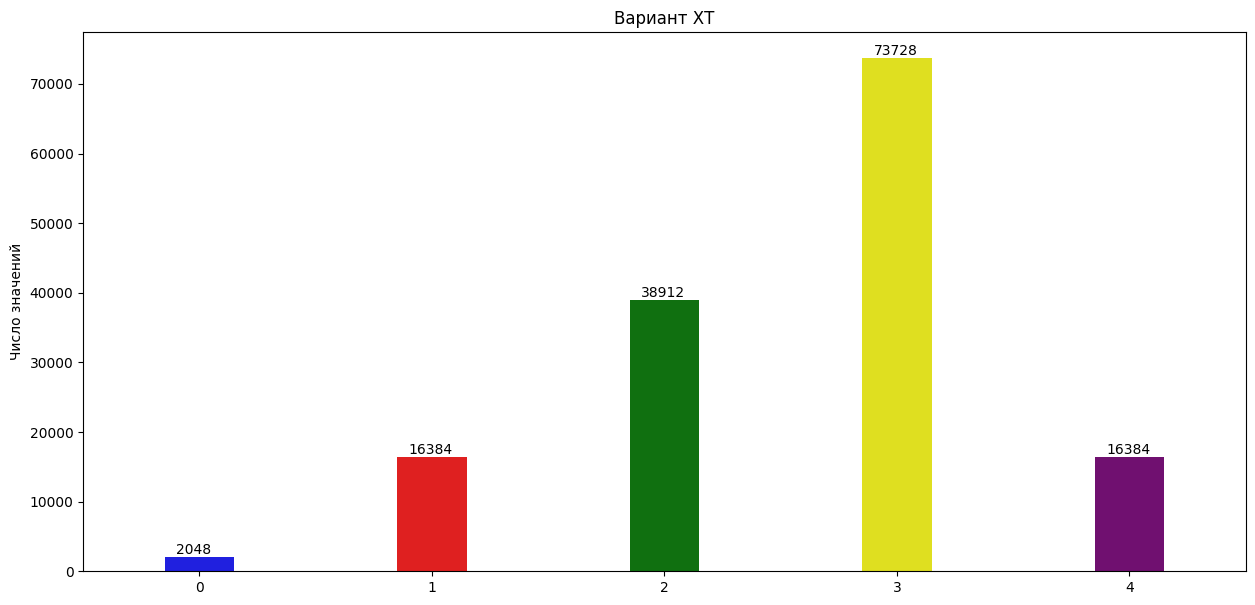


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №13: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 4
  0: 'паклитаксел+карбоплатин' -> кол-во: 65536
  1: 'этопозид карбоплатин' -> кол-во: 49152
  2: 'еженедельный паклитаксел+ карбоплатин' -> кол-во: 16384
  3: '0' -> кол-во: 16384


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)


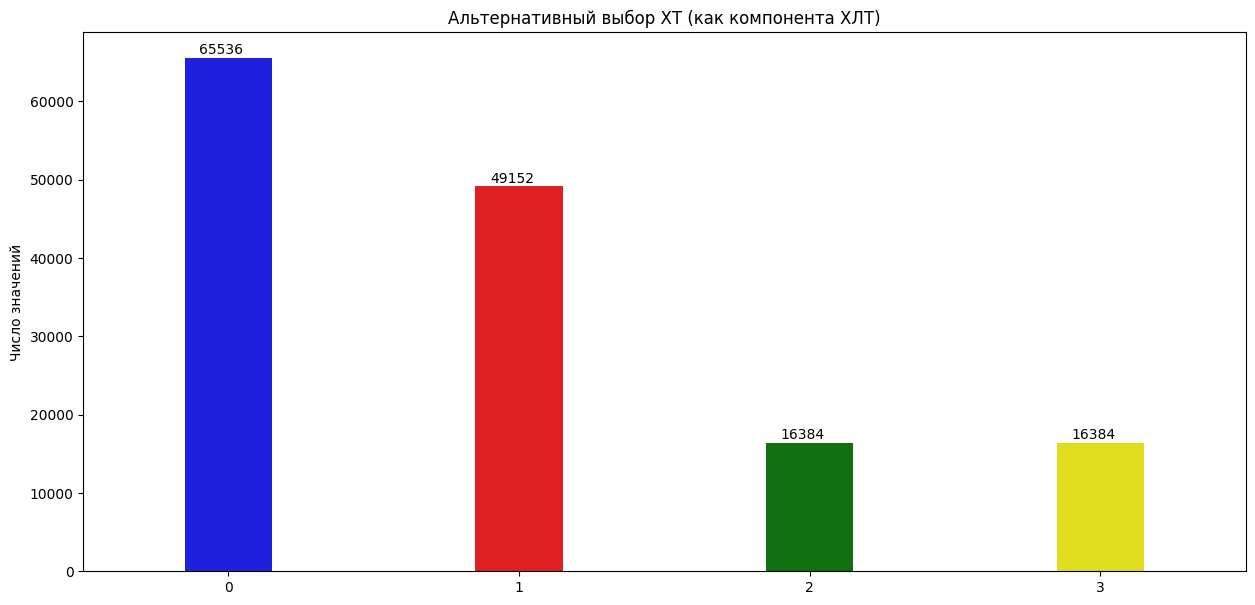


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №14: 'Поставьте галочку, если уверены на 100%'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'True' -> кол-во: 73728
  1: 'False' -> кол-во: 73728


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


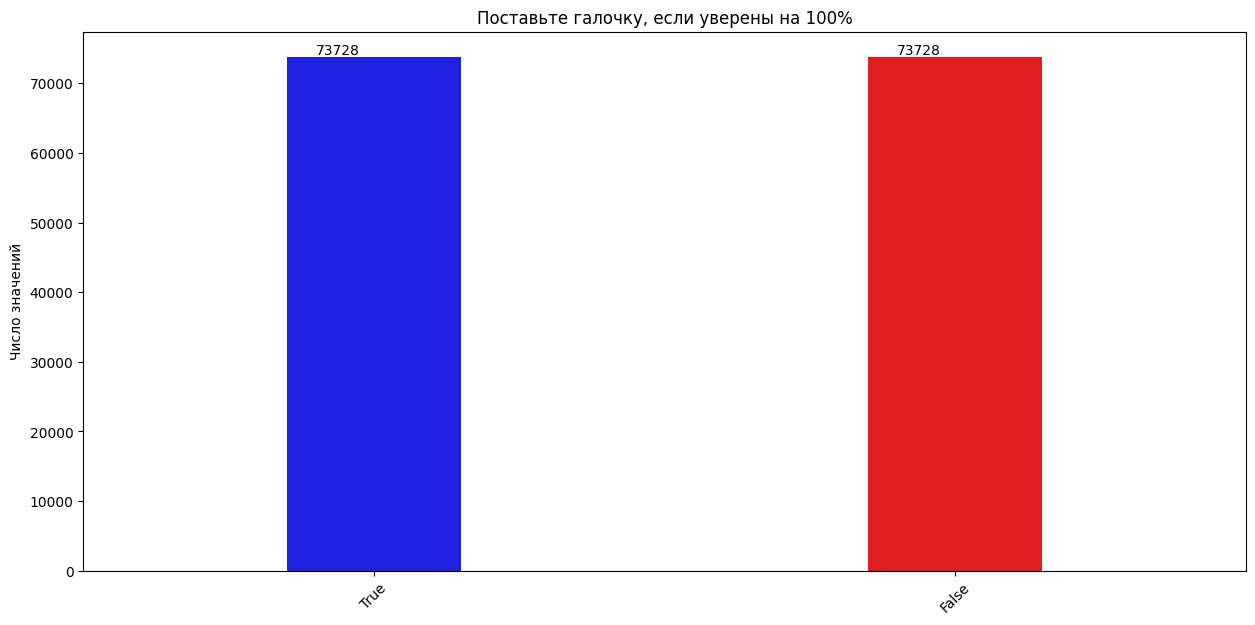


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №15: 'Если 75%'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'False' -> кол-во: 98304
  1: 'True' -> кол-во: 49152


C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)


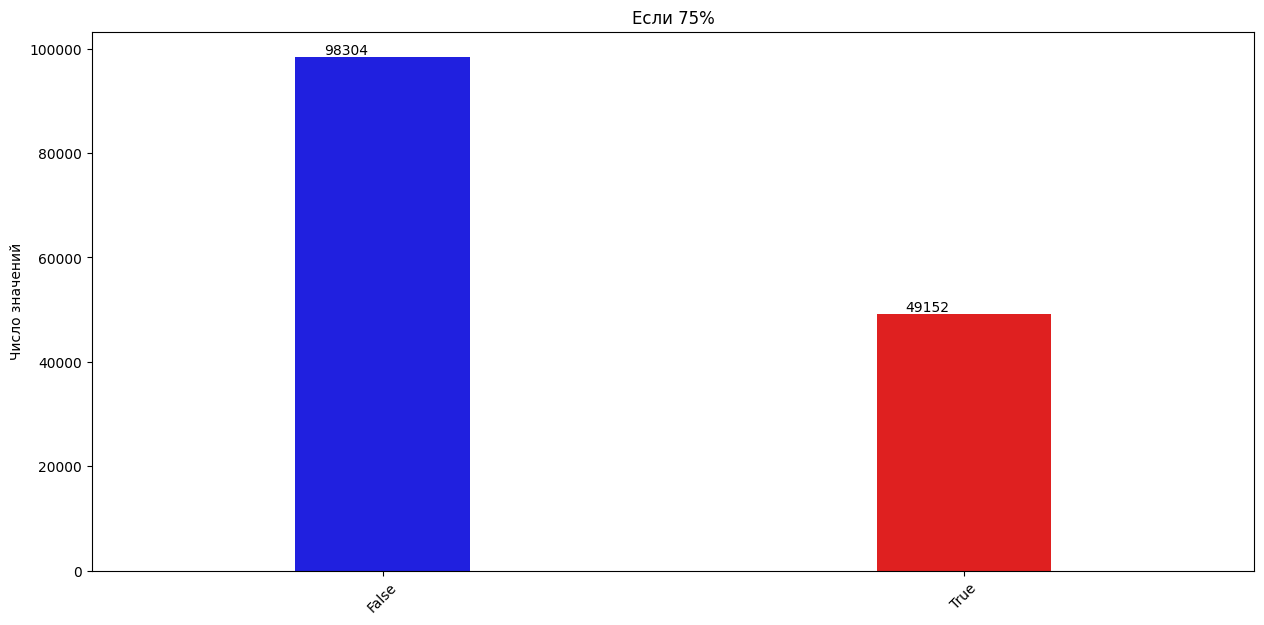

C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №16: 'Если 50%'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 2
  0: 'False' -> кол-во: 122880
  1: 'True' -> кол-во: 24576


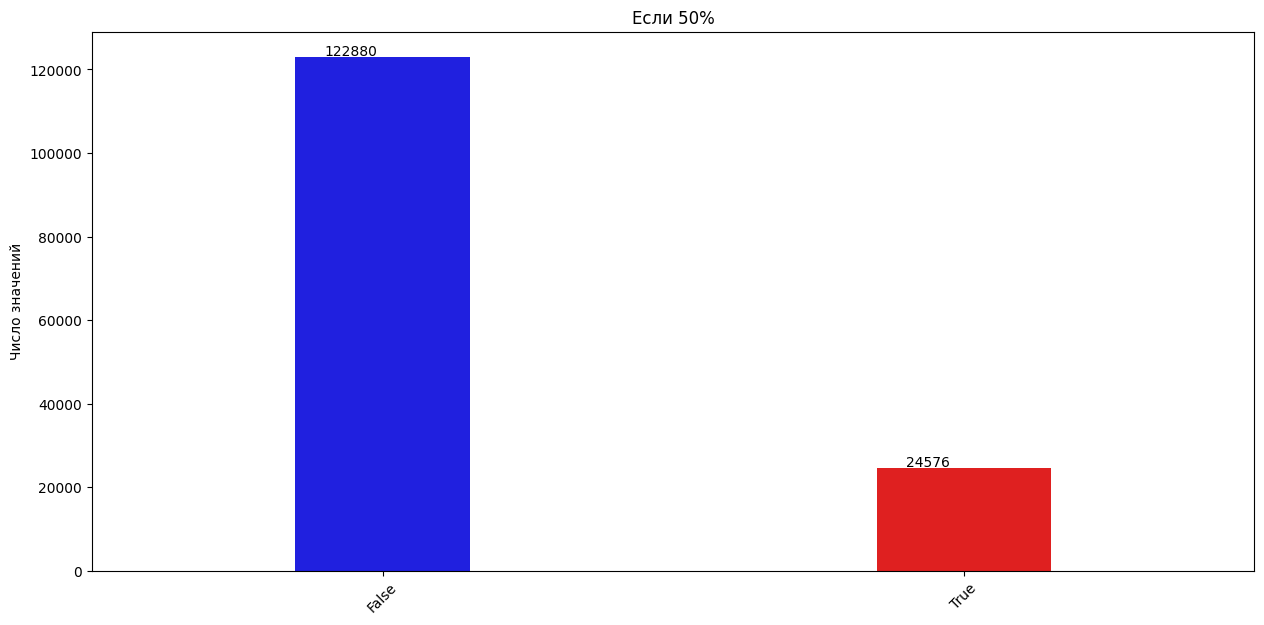

C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_str_labels2, y=count_array, palette=colors[:unique_count], width=0.3)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №17: 'Альтернатива, если 50% - обязательно'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 4
  0: '0' -> кол-во: 110592
  1: 'последовательная ХЛТ' -> кол-во: 12288
  2: 'Лучевая терапия в монорежиме' -> кол-во: 16384
  3: 'Симпоматическая терапия' -> кол-во: 8192


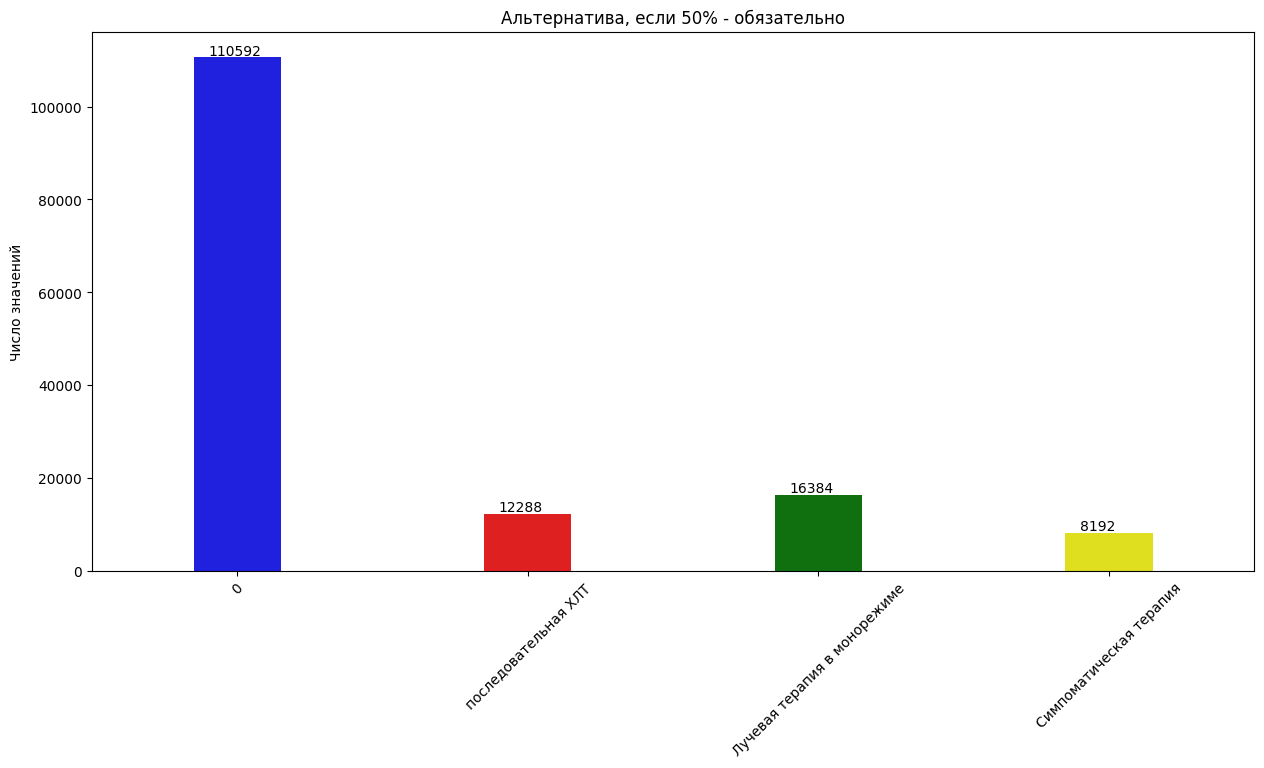


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Колонка №18: 'Комментарий'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
число строк с пустыми значениями: 0
число уникальных значений: 9
  0: 'Необходима консультация хирурга на предмет возможного удаления паренхиматозного очага распада. Если невозможно - тщательная оценка риска кровотечения перед началом лучевой терапии' -> кол-во: 2048
  1: '0' -> кол-во: 98304
  2: 'Необходима более детальная оценка сопутствующей патологии и чем именно обусловлен статус по шкале ECOG 2. Если основным заболеванием, то предпочтение отдаем одновременной ХЛТ, если все-таки тяжесть состояния обусловлена сопутсвующей патологией, то возможно выбрать последовательный вариант ХЛТ. При выборе одновременной ХЛТ, лучше рассмотреть вариант еженедельного введения химиотерапии' -> кол-во: 8192
  3: 'Необходима детальная оценка статуса по шкале ECOG. При мелко

C:\Users\alexe\AppData\Local\Temp\ipykernel_8768\3997239512.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot0 = sns.barplot(x=unique_int_labels1, y=count_array, palette=colors[:unique_count], width=0.3)


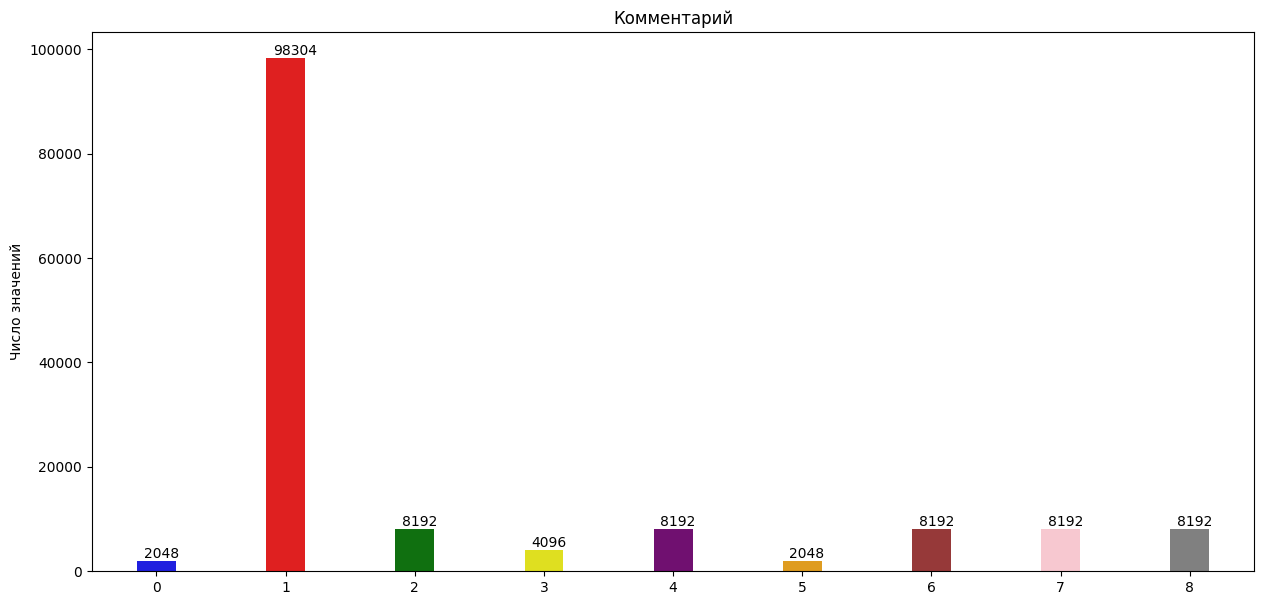

In [9]:
# Пробегаюсь по всем колонкам датафрейма и оцениваю балансировку
# i = 0
for col_name in df1_colnames:
  # print(f"i: {i}, col_name: '{col_name}'")
  # i += 1
  if 'id_ответа' == col_name:
    continue
  print_column_info(df1, col_name)

## Датафрейм для обучения нейронной сети


In [10]:
# Создаем датафрейм, который будет использоваться для обучения нейронной сети
# alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# 00 - 'A' - 'номер_ответа' ===> можно исключить
# 01 - 'B1' - 'Стадия' - 2типа
# 02 - 'C1','C2','C3' - 'Гистология' - 3типа
# 03 - 'D1','D2','D3' - 'ECOG' - 3типа
# 04 - 'E1' - 'Возраст' - 2типа
# 05 - 'F1' - 'Пол' - 2типа
# 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов
# 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа
# 08 - 'I1','I2','I3','I4' - 'Статус курения' - 4типа
# 09 - 'J1' - 'Относительные противопоказания к ЛТ' - 2типа
# 10 - 'K1' - 'Предпочтение пациента по ответу на терапию' - 2типа
#~~~
# 11 - L1 - 'Ответ эксперта (Лактионов)'
# 12 - L1 - 'Вариант ХТ'
# 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'
# 14 - L1 - 'Поставьте галочку, если уверены на 100%'
# 14 - L1 - 'Если 75%'
# 14 - L1 - 'Если 50%'
# 15 - L1 - 'Альтернатива, если 50% - обязательно'
# 16 - L1 - 'Комментарий'

dfxy1_cols = ['B1','C1','C2','C3','D1','D2','D3','E1','F1',
              'G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','G13','G14','G15','G16',
              'H1','H2','H3','H4','I1','I2','I3','I4','J1','K1','L1']
#~~~~~~~~~~~~~~~~~~~~~~~~
dfxy1 = pd.DataFrame(columns=dfxy1_cols, dtype=int)
print(f'размеры датафрейма dfxy1: {dfxy1.shape}')
print(f'  число строк: {dfxy1.shape[0]}')
print(f'  число колонок: {dfxy1.shape[1]}')

# dfxy1.info()

размеры датафрейма dfxy1: (0, 36)
  число строк: 0
  число колонок: 36


## 01 - 'B1' - 'Стадия' - 2типа

In [11]:
def print_unique_values(df, col_name):
  '''
  Функция отображение уникальных значений колонки

  Args:
    df - pandas.DataFrame
    col_name - column_name название колонки

  Returns:
    отображение иформации
  '''

  print(f"колонка: '{col_name}'")
  # строки с уникальными значениями unique_values
  unique_values = df1[col_name].unique().tolist()
  unique_count = len(unique_values)
  print(f'число уникальных значений: {unique_count}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  unique_values2 = list()
  for i in range(unique_count):
    u_item_str = str(unique_values[i])
    u_item_str2 = u_item_str.strip()
    unique_values2.append(u_item_str2)
  #~~~
  unique_values2.sort()

  #~~~~~~~~~~~~~~~~~~~~~~~~
  for i in range(unique_count):
    u_item_str2 = unique_values2[i]
    u_item_str3 = u_item_str2.lower()
    print(f"  {i}: '{u_item_str2}'; '{u_item_str3}'")

In [12]:
def check_categorization(df, col_name, cat_arr):
  '''
  Функция проверки категоризации

  Args:
    df - pandas.DataFrame
    col_name - column_name название колонки
    cat_arr - массив категоризованных значений

  Returns:
    отображение иформации
  '''

  print(f"колонка: '{col_name}'")
  # строки с уникальными значениями unique_values
  unique_values = df1[col_name].unique().tolist()
  unique_count = len(unique_values)
  print(f'число уникальных значений: {unique_count}')
  equal_items = 0
  for i in range(unique_count):
    u_item_str = str(unique_values[i])
    row_inx = 0
    for elem_val in df1[col_name]:
      elem_str = str(elem_val)
      if u_item_str == elem_str:
        print(f"  {i}: '{u_item_str}', category code: {cat_arr[row_inx]}, row index: {row_inx}")
        equal_items += 1
        break
      row_inx += 1
  print(f'  число элементов, по которым произведена проверка категориального кодирования: {equal_items}')

In [13]:
# 1->19: 'Стадия'
# трансформирую значения в категориальные и добавляю их в датафрейм
inx1 = 1
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Стадия'
число уникальных значений: 2
  0: 'IIIаI'; 'iiiаi'
  1: 'IIIб'; 'iiiб'


In [14]:
def getStageCode(str_val):
  '''
  Получение категориального значения `Стадия` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Стадия'
    число уникальных значений: 2
      0: ' IIIаI', 'iiiаi'
      1: ' IIIб', 'iiiб'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'iiiаi' == str2:
    retVal = 0
  elif 'iiiб' == str2:
    retVal = 1

  return retVal

In [15]:
# создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
# cat - category
cat_arr1 = np.zeros(df1.shape[0], dtype=int)

#~~~~~~~~~~~~~~~~~~~~~~~~
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getStageCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Стадия'
число уникальных значений: 2
  0: 'IIIаI', category code: 0, row index: 0
  1: 'IIIб', category code: 1, row index: 1
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [16]:
# добавляем данные в датафрейм
# 01 - 'B1' - 'Стадия' - 2типа
dfxy1 = dfxy1.assign(B1=cat_arr1)
# dfxy1.head(3)
# dfxy1.tail(3)

In [17]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 02 - 'C1','C2','C3' - 'Гистология' - 3типа

In [18]:
# 2->19: 'Гистология'
inx1 = 2
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Гистология'
число уникальных значений: 3
  0: 'мелкоклеточный'; 'мелкоклеточный'
  1: 'неплоскоклеточный'; 'неплоскоклеточный'
  2: 'плоскоклеточный'; 'плоскоклеточный'


In [19]:
def getHistologyCode(str_val):
  '''
  Получение категориального значения `Гистология` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Гистология'
    число уникальных значений: 3
      0: ' плоскоклеточный'; 'плоскоклеточный'
      1: ' неплоскоклеточный'; 'неплоскоклеточный'
      2: ' мелкоклеточный'; 'мелкоклеточный'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'плоскоклеточный' == str2:
    retVal = 0
  elif 'неплоскоклеточный' == str2:
    retVal = 1
  elif 'мелкоклеточный' == str2:
    retVal = 2

  return retVal

In [20]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getHistologyCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Гистология'
число уникальных значений: 3
  0: ' плоскоклеточный', category code: 0, row index: 0
  1: ' неплоскоклеточный', category code: 1, row index: 2
  2: ' мелкоклеточный', category code: 2, row index: 4
  число элементов, по которым произведена проверка категориального кодирования: 3
число строк, которые не прошли категоризацию: 0


In [21]:
#~ преобразование массива в формат one-hot-encoding (3-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 3)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 02 - 'C1','C2','C3' - 'Гистология' - 3типа
dfxy1 = dfxy1.assign(C1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(C2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(C3=cat_arr2_i[:, 2])

del cat_arr2
del cat_arr2_i

## 03 - 'D1','D2','D3' - 'ECOG' - 3типа

In [22]:
# 3->19: 'ECOG'
inx1 = 3
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'ECOG'
число уникальных значений: 3
  0: '0-1'; '0-1'
  1: '2'; '2'
  2: '3+'; '3+'


In [23]:
def getEcogCode(str_val):
  '''
  Получение категориального значения `ECOG` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'ECOG'
    число уникальных значений: 3
      0: '  0-1'; '0-1'
      1: '2'; '2'
      2: ' 3+'; '3+'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if '0-1' == str2:
    retVal = 0
  elif '2' == str2:
    retVal = 1
  elif '3+' == str2:
    retVal = 2

  return retVal

In [24]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getEcogCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'ECOG'
число уникальных значений: 3
  0: '  0-1', category code: 0, row index: 0
  1: '2', category code: 1, row index: 12
  2: ' 3+', category code: 2, row index: 24
  число элементов, по которым произведена проверка категориального кодирования: 3
число строк, которые не прошли категоризацию: 0


In [25]:
#~ преобразование массива в формат one-hot-encoding (3-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 3)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 03 - 'D1','D2','D3' - 'ECOG' - 3типа
dfxy1 = dfxy1.assign(D1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(D2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(D3=cat_arr2_i[:, 2])

del cat_arr2
del cat_arr2_i

In [26]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,1,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,1,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 04 - 'E1' - 'Возраст' - 2типа

In [27]:
# 4->19: 'Возраст'
inx1 = 4
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Возраст'
число уникальных значений: 2
  0: '>70'; '>70'
  1: 'До 70'; 'до 70'


In [28]:
def getAgeCode(str_val):
  '''
  Получение категориального значения `Возраст` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Возраст'
    число уникальных значений: 2
      0: ' До 70'; 'до 70'
      1: ' >70'; '>70'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'до 70' == str2:
    retVal = 0
  elif '>70' == str2:
    retVal = 1

  return retVal

In [29]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getAgeCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Возраст'
число уникальных значений: 2
  0: ' До 70', category code: 0, row index: 0
  1: ' >70', category code: 1, row index: 36
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [30]:
# добавляем данные в датафрейм
# 04 - 'E1' - 'Возраст' - 2типа
dfxy1 = dfxy1.assign(E1=cat_arr1)

In [31]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,1,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,1,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 05 - 'F1' - 'Пол' - 2типа

In [32]:
# 5->19: 'Пол'
inx1 = 5
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Пол'
число уникальных значений: 2
  0: 'Женский'; 'женский'
  1: 'Мужской'; 'мужской'


In [33]:
def getGenderCode(str_val):
  '''
  Получение категориального значения `Пол` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Пол'
    число уникальных значений: 2
      0: 'Мужской'; 'мужской'
      1: 'Женский'; 'женский'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'мужской' == str2:
    retVal = 0
  elif 'женский' == str2:
    retVal = 1

  return retVal

In [34]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getGenderCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Пол'
число уникальных значений: 2
  0: 'Мужской', category code: 0, row index: 0
  1: 'Женский', category code: 1, row index: 72
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [35]:
# добавляем данные в датафрейм
# 05 - 'F1' - 'Пол' - 2типа
dfxy1 = dfxy1.assign(F1=cat_arr1)

In [36]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,1,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,1,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов


In [37]:
# 6->19: 'Молекулярный статус (только для неплоскоклеточного рака)'
inx1 = 6
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Молекулярный статус (только для неплоскоклеточного рака)'
число уникальных значений: 16
  0: 'ALK'; 'alk'
  1: 'BRAF'; 'braf'
  2: 'EGFR (G719X, L816Q, S768I)'; 'egfr (g719x, l816q, s768i)'
  3: 'EGFR T790M'; 'egfr t790m'
  4: 'EGFR ex18'; 'egfr ex18'
  5: 'EGFR ex19'; 'egfr ex19'
  6: 'EGFR ex20'; 'egfr ex20'
  7: 'EGFR ex21'; 'egfr ex21'
  8: 'HER2'; 'her2'
  9: 'KRAS G12C'; 'kras g12c'
  10: 'MET 14ex'; 'met 14ex'
  11: 'NTRK'; 'ntrk'
  12: 'RET'; 'ret'
  13: 'ROS1'; 'ros1'
  14: 'не исследовались'; 'не исследовались'
  15: 'нет мутаций'; 'нет мутаций'


In [38]:
def getMolecularStatusCode(str_val):
  '''
  Получение категориального значения `Молекулярный статус (только для неплоскоклеточного рака)` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Молекулярный статус (только для неплоскоклеточного рака)'
    число уникальных значений: 16
      0: 'не исследовались'; 'не исследовались'
      1: 'нет мутаций'; 'нет мутаций'
      2: 'ALK'; 'alk'
      3: 'BRAF'; 'braf'
      4: 'EGFR (G719X, L816Q, S768I)'; 'egfr (g719x, l816q, s768i)'
      5: 'EGFR T790M'; 'egfr t790m'
      6: 'EGFR ex18'; 'egfr ex18'
      7: 'EGFR ex19'; 'egfr ex19'
      8: 'EGFR ex20'; 'egfr ex20'
      9: 'EGFR ex21'; 'egfr ex21'
      10: 'HER2'; 'her2'
      11: 'KRAS G12C'; 'kras g12c'
      12: 'MET 14ex'; 'met 14ex'
      13: 'NTRK'; 'ntrk'
      14: 'RET'; 'ret'
      15: 'ROS1'; 'ros1'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'не исследовались' == str2:
    retVal = 0
  elif 'нет мутаций' == str2:
    retVal = 1
  elif 'alk' == str2:
    retVal = 2
  elif 'braf' == str2:
    retVal = 3
  elif 'egfr (g719x, l816q, s768i)' == str2:
    retVal = 4
  elif 'egfr t790m' == str2:
    retVal = 5
  elif 'egfr ex18' == str2:
    retVal = 6
  elif 'egfr ex19' == str2:
    retVal = 7
  elif 'egfr ex20' == str2:
    retVal = 8
  elif 'egfr ex21' == str2:
    retVal = 9
  elif 'her2' == str2:
    retVal = 10
  elif 'kras g12c' == str2:
    retVal = 11
  elif 'met 14ex' == str2:
    retVal = 12
  elif 'ntrk' == str2:
    retVal = 13
  elif 'ret' == str2:
    retVal = 14
  elif 'ros1' == str2:
    retVal = 15

  return retVal

In [39]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getMolecularStatusCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Молекулярный статус (только для неплоскоклеточного рака)'
число уникальных значений: 16
  0: ' нет мутаций', category code: 1, row index: 0
  1: ' не исследовались', category code: 0, row index: 1152
  2: ' EGFR ex19', category code: 7, row index: 2304
  3: ' EGFR ex21', category code: 9, row index: 3456
  4: ' EGFR ex18', category code: 6, row index: 4608
  5: ' EGFR ex20', category code: 8, row index: 5760
  6: ' EGFR T790M', category code: 5, row index: 6912
  7: ' EGFR (G719X, L816Q, S768I)', category code: 4, row index: 8064
  8: ' ALK', category code: 2, row index: 9216
  9: ' ROS1', category code: 15, row index: 10368
  10: ' BRAF', category code: 3, row index: 11520
  11: ' RET', category code: 14, row index: 12672
  12: ' MET 14ex', category code: 12, row index: 13824
  13: ' HER2', category code: 10, row index: 14976
  14: ' KRAS G12C', category code: 11, row index: 16128
  15: ' NTRK', category code: 13, row index: 17280
  число элементов, по которым произведена пр

In [40]:
#~ преобразование массива в формат one-hot-encoding (16-классов)
cat_arr2 = utils.to_categorical(cat_arr1, 16)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов
dfxy1 = dfxy1.assign(G1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(G2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(G3=cat_arr2_i[:, 2])
dfxy1 = dfxy1.assign(G4=cat_arr2_i[:, 3])
dfxy1 = dfxy1.assign(G5=cat_arr2_i[:, 4])
dfxy1 = dfxy1.assign(G6=cat_arr2_i[:, 5])
dfxy1 = dfxy1.assign(G7=cat_arr2_i[:, 6])
dfxy1 = dfxy1.assign(G8=cat_arr2_i[:, 7])
dfxy1 = dfxy1.assign(G9=cat_arr2_i[:, 8])
dfxy1 = dfxy1.assign(G10=cat_arr2_i[:, 9])
dfxy1 = dfxy1.assign(G11=cat_arr2_i[:, 10])
dfxy1 = dfxy1.assign(G12=cat_arr2_i[:, 11])
dfxy1 = dfxy1.assign(G13=cat_arr2_i[:, 12])
dfxy1 = dfxy1.assign(G14=cat_arr2_i[:, 13])
dfxy1 = dfxy1.assign(G15=cat_arr2_i[:, 14])
dfxy1 = dfxy1.assign(G16=cat_arr2_i[:, 15])

del cat_arr2
del cat_arr2_i

In [41]:
def print_cell_value(df, row_idx, col_name):
  '''
  Функция отображает значение ячейки

  Args:
    df - pandas.DataFrame
    row_idx - индекс строки
    col_name - название колонки в dfxy
  Returns:
    отображение значения ячейки
  '''
  col_idx = df.columns.get_loc(col_name)
  # print(f'col_name: `{col_name}`, col_idx: `{col_idx}`')
  print(f'строка: {row_idx}, колонка: {col_idx}, значение: {df.iloc[row_idx, col_idx]}')

In [42]:
# 06 - 'G1','G2'...'G16' - 'Молекулярный статус (только для неплоскоклеточного рака)' - 16типов
print_cell_value(df1, 0, 'Молекулярный статус (только для неплоскоклеточного рака)')
print_cell_value(dfxy1, 0, 'G1')
print_cell_value(dfxy1, 0, 'G2')
print_cell_value(dfxy1, 0, 'G3')
print_cell_value(dfxy1, 0, 'G4')
print_cell_value(dfxy1, 0, 'G5')
print_cell_value(dfxy1, 0, 'G6')
print_cell_value(dfxy1, 0, 'G7')
print_cell_value(dfxy1, 0, 'G8')
print_cell_value(dfxy1, 0, 'G9')
print_cell_value(dfxy1, 0, 'G10')
print_cell_value(dfxy1, 0, 'G11')
print_cell_value(dfxy1, 0, 'G12')
print_cell_value(dfxy1, 0, 'G13')
print_cell_value(dfxy1, 0, 'G14')
print_cell_value(dfxy1, 0, 'G15')
print_cell_value(dfxy1, 0, 'G16')

строка: 0, колонка: 6, значение:  нет мутаций
строка: 0, колонка: 9, значение: 0
строка: 0, колонка: 10, значение: 1
строка: 0, колонка: 11, значение: 0
строка: 0, колонка: 12, значение: 0
строка: 0, колонка: 13, значение: 0
строка: 0, колонка: 14, значение: 0
строка: 0, колонка: 15, значение: 0
строка: 0, колонка: 16, значение: 0
строка: 0, колонка: 17, значение: 0
строка: 0, колонка: 18, значение: 0
строка: 0, колонка: 19, значение: 0
строка: 0, колонка: 20, значение: 0
строка: 0, колонка: 21, значение: 0
строка: 0, колонка: 22, значение: 0
строка: 0, колонка: 23, значение: 0
строка: 0, колонка: 24, значение: 0


## 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа

In [43]:
# 7->19: 'PD-L1 статус'
inx1 = 7
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'PD-L1 статус'
число уникальных значений: 4
  0: '0.01'; '0.01'
  1: '1–49 %'; '1–49 %'
  2: 'не исследовался'; 'не исследовался'
  3: '≥50 %'; '≥50 %'


In [44]:
def getPD_L1StatusCode(str_val):
  '''
  Получение категориального значения `PD-L1 статус` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'PD-L1 статус'
    число уникальных значений: 4
      0: 'не исследовался' ===> 'неисследовался'
      1: '0.01','1%'       ===> '0.01', '1'
      2: '1–49 %'          ===> '1–49'
      3: '≥50 %'           ===> '≥50'
  '''

  str2 = str_val.lower().strip()
  str3 = str2.replace('%', '').replace(' ', '')
  str4 = str3.strip()

  retVal = -1
  if 'неисследовался' == str4:
    retVal = 0
  elif '0.01' == str4:
    retVal = 1
  elif '1' == str4:
    retVal = 1
  elif '1–49' == str4:
    retVal = 2
  elif '≥50' == str4:
    retVal = 3

  return retVal

In [45]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getPD_L1StatusCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'PD-L1 статус'
число уникальных значений: 4
  0: ' не исследовался', category code: 0, row index: 0
  1: '0.01', category code: 1, row index: 18432
  2: ' 1–49 %', category code: 2, row index: 36864
  3: ' ≥50 %', category code: 3, row index: 55296
  число элементов, по которым произведена проверка категориального кодирования: 4
число строк, которые не прошли категоризацию: 0


In [46]:
#~ преобразование массива в формат one-hot-encoding (4-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 4)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа
dfxy1 = dfxy1.assign(H1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(H2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(H3=cat_arr2_i[:, 2])
dfxy1 = dfxy1.assign(H4=cat_arr2_i[:, 3])

del cat_arr2
del cat_arr2_i

In [47]:
# 07 - 'H1','H2','H3','H4' - 'PD-L1 статус' - 4типа
print_cell_value(df1, 0, 'PD-L1 статус')
print_cell_value(dfxy1, 0, 'H1')
print_cell_value(dfxy1, 0, 'H2')
print_cell_value(dfxy1, 0, 'H3')
print_cell_value(dfxy1, 0, 'H4')

строка: 0, колонка: 7, значение:  не исследовался
строка: 0, колонка: 25, значение: 1
строка: 0, колонка: 26, значение: 0
строка: 0, колонка: 27, значение: 0
строка: 0, колонка: 28, значение: 0


## 08 - 'I1','I2','I3','I4' - 'Статус курения' - 4типа

In [48]:
# 8->19: 'Статус курения'
inx1 = 8
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Статус курения'
число уникальных значений: 4
  0: 'В настоящее время'; 'в настоящее время'
  1: 'Курение в прошлом (бросил более 1 года)'; 'курение в прошлом (бросил более 1 года)'
  2: 'Курение в прошлом (бросил более 1 месяца до 1 года)'; 'курение в прошлом (бросил более 1 месяца до 1 года)'
  3: 'Никогда не курил'; 'никогда не курил'


In [49]:
def getSmokingStatusCode(str_val):
  '''
  Получение категориального значения `Статус курения` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Статус курения'
    число уникальных значений: 4
      0: ' В настоящее время'; 'в настоящее время'
      1: ' Курение в прошлом (бросил более 1 месяца до 1 года)'; 'курение в прошлом (бросил более 1 месяца до 1 года)'
      2: ' Курение в прошлом (бросил более 1 года)'; 'курение в прошлом (бросил более 1 года)'
      3: ' Никогда не курил'; 'никогда не курил'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'в настоящее время' == str2:
    retVal = 0
  elif 'курение в прошлом (бросил более 1 месяца до 1 года)' == str2:
    retVal = 1
  elif 'курение в прошлом (бросил более 1 года)' == str2:
    retVal = 2
  elif 'никогда не курил' == str2:
    retVal = 3

  return retVal

In [50]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getSmokingStatusCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Статус курения'
число уникальных значений: 4
  0: ' В настоящее время', category code: 0, row index: 0
  1: ' Курение в прошлом (бросил более 1 месяца до 1 года)', category code: 1, row index: 144
  2: ' Курение в прошлом (бросил более 1 года)', category code: 2, row index: 288
  3: ' Никогда не курил', category code: 3, row index: 432
  число элементов, по которым произведена проверка категориального кодирования: 4
число строк, которые не прошли категоризацию: 0


In [51]:
#~ преобразование массива в формат one-hot-encoding (4-класса)
cat_arr2 = utils.to_categorical(cat_arr1, 4)
#~ приведение типа элементов массива
cat_arr2_i = cat_arr2.astype(int)

#~ добавляем данные по столбцам в датафрейм
#~ 08 - 'I1','I2','I3','I4' - 'Статус курения' - 4типа
dfxy1 = dfxy1.assign(I1=cat_arr2_i[:, 0])
dfxy1 = dfxy1.assign(I2=cat_arr2_i[:, 1])
dfxy1 = dfxy1.assign(I3=cat_arr2_i[:, 2])
dfxy1 = dfxy1.assign(I4=cat_arr2_i[:, 3])

del cat_arr2
del cat_arr2_i

In [52]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN


## 09 - 'J1' - 'Относительные противопоказания к ЛТ' - 2типа

In [53]:
# 9->19: 'Относительные противопоказания к ЛТ'
inx1 = 9
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Относительные противопоказания к ЛТ'
число уникальных значений: 2
  0: 'да'; 'да'
  1: 'нет'; 'нет'


In [54]:
def getNoYesCodeStr(str_val):
  '''
  Получение категориального значения `нет-да` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    число уникальных значений: 2
    0: ' нет', 'нет'
    1: ' да', 'да'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'нет' == str2:
    retVal = 0
  elif 'да' == str2:
    retVal = 1

  return retVal  

In [55]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getNoYesCodeStr(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Относительные противопоказания к ЛТ'
число уникальных значений: 2
  0: ' да', category code: 1, row index: 0
  1: ' нет', category code: 0, row index: 6
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [56]:
# 09 - 'J1' - 'Относительные противопоказания к ЛТ' - 2типа
dfxy1 = dfxy1.assign(J1=cat_arr1)

In [57]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,NaN,NaN
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,NaN,NaN
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,NaN,NaN


## 10 - 'K1' - 'Предпочтение пациента по ответу на терапию' - 2типа

In [58]:
# 10->19: 'Предпочтение пациента по ответу на терапию'
inx1 = 10
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Предпочтение пациента по ответу на терапию'
число уникальных значений: 2
  0: 'результативность лечения'; 'результативность лечения'
  1: 'сохранение качества жизни'; 'сохранение качества жизни'


In [59]:
def getPatientPreferenceCode(str_val):
  '''
  Получение категориального значения `Предпочтение пациента по ответу на терапию` по текстовому значению

  Args:
    str_val - текстовое значение

  Returns:
    колонка: 'Предпочтение пациента по ответу на терапию'
    число уникальных значений: 2
      0: 'результативность лечения'; 'результативность лечения'
      1: 'сохранение качества жизни'; 'сохранение качества жизни'
  '''

  str2 = str_val.lower().strip()
  retVal = -1
  if 'результативность лечения' == str2:
    retVal = 0
  elif 'сохранение качества жизни' == str2:
    retVal = 1

  return retVal

In [60]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getPatientPreferenceCode(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Предпочтение пациента по ответу на терапию'
число уникальных значений: 2
  0: ' результативность лечения', category code: 0, row index: 0
  1: ' сохранение качества жизни', category code: 1, row index: 73728
  число элементов, по которым произведена проверка категориального кодирования: 2
число строк, которые не прошли категоризацию: 0


In [61]:
# 10 - 'K1' - 'Предпочтение пациента по ответу на терапию' - 2типа
dfxy1 = dfxy1.assign(K1=cat_arr1)

In [62]:
dfxy1.head(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,NaN
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,NaN
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,NaN


## 11-18 - L1 - 'Ответ эксперта (Лактионов)'

### 11 - L1 - 'Ответ эксперта (Лактионов)'

In [63]:
# 11 - L1 - 'Ответ эксперта (Лактионов)'
inx1 = 11
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Ответ эксперта (Лактионов)'
число уникальных значений: 3
  0: 'Симптоматическая терапия'; 'симптоматическая терапия'
  1: 'одномоментная ХЛТ'; 'одномоментная хлт'
  2: 'последовательная ХЛТ'; 'последовательная хлт'


In [64]:
def getExpertRecommendationCode12(str_val):
  '''
  Получение категориального значения `Ответ эксперта (Денисова,Савченко)` по текстовому значению
  Args:
    str_val - текстовое значение
  Returns:
    колонка: 'Ответ эксперта (Денисова,Савченко)'
    число уникальных значений: 3
      0: 'Симптоматическая терапия'; 'симптоматическая терапия'
      1: 'одномоментная ХЛТ'; 'одномоментная хлт'
      2: 'последовательная ХЛТ'; 'последовательная хлт'
  '''
  str2 = str_val.lower().strip()
  retVal = -1
  #~~~ +1 -> для сборки одного кода-рекомендации
  if 'симптоматическая терапия' == str2:
    retVal = 1
  elif 'одномоментная хлт' == str2:
    retVal = 2
  elif 'последовательная хлт' == str2:
    retVal = 3
  return retVal

In [65]:
def getReverseExpertRecommendationCode12(num):
  '''
  Получение текстового значения `Ответ эксперта (Денисова,Савченко)` по категориальному значению
  Args:
    num - числовое категориальное значение
  Returns:
    текстовое значение
  '''
  retVal = '-'
  if 1 == num:
    retVal = 'симптоматическая терапия'
  elif 2 == num:
    retVal = 'одномоментная ХЛТ'
  elif 3 == num:
    retVal = 'последовательная ХЛТ'
  return retVal

In [66]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getExpertRecommendationCode12(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Ответ эксперта (Лактионов)'
число уникальных значений: 3
  0: 'одномоментная ХЛТ', category code: 2, row index: 0
  1: 'последовательная ХЛТ', category code: 3, row index: 12
  2: 'Симптоматическая терапия', category code: 1, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 3
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 2


### 12 - L1 - 'Вариант ХТ'

In [67]:
# 12 - L1 - 'Вариант ХТ'
inx1 = 12
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Вариант ХТ'
число уникальных значений: 5
  0: '0'; '0'
  1: 'Этопозид цисплатин'; 'этопозид цисплатин'
  2: 'Этопозид цисплатин/карбоплатин Дурвалумаб'; 'этопозид цисплатин/карбоплатин дурвалумаб'
  3: 'пеметрексед+цисплатин'; 'пеметрексед+цисплатин'
  4: 'этопозид+цисплатин'; 'этопозид+цисплатин'


In [68]:
def getChemotherapyVariantCode12(str_val):
  '''
  Получение категориального значения `Вариант ХТ` по текстовому значению
  Args:
    str_val - текстовое значение
  Returns:
    колонка: 'Вариант ХТ'
    число уникальных значений: 4
    #~~~ +1*10 -> для сборки одного кода-рекомендации
      0|0                                         ===> (0+1)*10=10
      1|пеметрексед+цисплатин                     ===> (1+1)*10=20
        этопозид цисплатин
      2|этопозид+цисплатин                        ===> (2+1)*10=30
      3|этопозид цисплатин/карбоплатин дурвалумаб ===> (3+1)*10=40
  '''
  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 10
  elif 'пеметрексед+цисплатин' == str2:
    retVal = 20
  elif 'этопозид цисплатин' == str2:
    retVal = 30
  elif 'этопозид+цисплатин' == str2:
    retVal = 30
  elif 'этопозид цисплатин/карбоплатин дурвалумаб' == str2:
    retVal = 40
  return retVal

In [69]:
def getReverseChemotherapyVariantCode12(num):
  '''
  Получение текстового значения `Вариант ХТ` по категориальному значению
  Args:
    num - числовое категориальное значение
  Returns:
    текстовое значение
  '''
  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'Пеметрексед+цисплатин'
  elif 3 == num:
    retVal = 'Этопозид+цисплатин'
  elif 4 == num:
    retVal = 'Этопозид цисплатин/карбоплатин Дурвалумаб'
  return retVal

In [70]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getChemotherapyVariantCode12(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Вариант ХТ'
число уникальных значений: 5
  0: 'Этопозид цисплатин/карбоплатин Дурвалумаб', category code: 42, row index: 0
  1: 'Этопозид цисплатин', category code: 32, row index: 1
  2: 'пеметрексед+цисплатин', category code: 22, row index: 2
  3: 'этопозид+цисплатин', category code: 32, row index: 4
  4: '0', category code: 11, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 5
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 42


### 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'

In [71]:
# 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'
inx1 = 13
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
число уникальных значений: 4
  0: '0'; '0'
  1: 'еженедельный паклитаксел+ карбоплатин'; 'еженедельный паклитаксел+ карбоплатин'
  2: 'паклитаксел+карбоплатин'; 'паклитаксел+карбоплатин'
  3: 'этопозид карбоплатин'; 'этопозид карбоплатин'


In [72]:
def getAlternativeChemotherapyVariantCode12(str_val):
  '''
  Получение категориального значения `Альтернативный выбор ХТ (как компонента ХЛТ)` по текстовому значению
  Args:
    str_val - текстовое значение
  Returns:
    колонка: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
    число уникальных значений: 4
    #~~~ +1*100 -> для сборки одного кода-рекомендации
      0|0                                     ===> (0+1)*100=100
      1|еженедельный паклитаксел+ карбоплатин ===> (1+1)*100=200
      2|паклитаксел+карбоплатин               ===> (2+1)*100=300
      3|этопозид карбоплатин                  ===> (3+1)*100=400
  '''
  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 100
  elif 'еженедельный паклитаксел+ карбоплатин' == str2:
    retVal = 200
  elif 'паклитаксел+карбоплатин' == str2:
    retVal = 300
  elif 'этопозид карбоплатин' == str2:
    retVal = 400
  return retVal

In [73]:
def getReverseAlternativeChemotherapyVariantCode12(num):
  '''
  Получение текстового значения `Альтернативный выбор ХТ (как компонента ХЛТ)` по категориальному значению
  Args:
    num - числовое категориальное значение
  Returns:
    текстовое значение
  '''
  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'еженедельный Паклитаксел+карбоплатин'
  elif 3 == num:
    retVal = 'Паклитаксел+карбоплатин'
  elif 4 == num:
    retVal = 'Этопозид карбоплатин'
  return retVal

In [74]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getAlternativeChemotherapyVariantCode12(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Альтернативный выбор ХТ (как компонента ХЛТ)'
число уникальных значений: 4
  0: 'паклитаксел+карбоплатин', category code: 342, row index: 0
  1: 'этопозид карбоплатин', category code: 432, row index: 4
  2: 'еженедельный паклитаксел+ карбоплатин', category code: 232, row index: 18
  3: '0', category code: 111, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 4
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 342


### 14 - L1 - 'Поставьте галочку, если уверены на 100%', 17 - N - 'Если 75%', 18 - N - 'Если 50%'

In [75]:
# 14 - L1 - 'Поставьте галочку, если уверены на 100%'
inx100 = 14
col_name100 = df1_colnames[inx100]
print_unique_values(df1, col_name100)

колонка: 'Поставьте галочку, если уверены на 100%'
число уникальных значений: 2
  0: 'False'; 'false'
  1: 'True'; 'true'


In [76]:
# 15 - L1 - 'Если 75%''
inx75 = 15
col_name75 = df1_colnames[inx75]
print_unique_values(df1, col_name75)

колонка: 'Если 75%'
число уникальных значений: 2
  0: 'False'; 'false'
  1: 'True'; 'true'


In [77]:
# 16 - L1 - 'Если 50%'
inx50 = 16
col_name50 = df1_colnames[inx50]
print_unique_values(df1, col_name50)

колонка: 'Если 50%'
число уникальных значений: 2
  0: 'False'; 'false'
  1: 'True'; 'true'


In [78]:
def getNoYesCodeBool(bool_val):
  '''
  Получение категориального значения `False-True` по bool значению

  Args:
    bool_val - bool значение

  Returns:
    число уникальных значений: 2
    0: False
    1: True
  '''

  retVal = -1
  if False == bool_val:
    retVal = 0
  elif True == bool_val:
    retVal = 1

  return retVal

In [79]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~проверяю что все три значения 100%, 75%, 50% являются взаимоисключающими
#~~~100%
#~ 14  Поставьте галочку, если уверены на 100%                   147456 non-null  bool
#~ 15  Если 75%                                                  147456 non-null  bool
#~ 16  Если 50%                                                  147456 non-null  bool

cat_arr100 = np.zeros(df1.shape[0], dtype=int)
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name100]:
  elem_bool1 = bool(elem_val1)
  # print(f'elem_bool1: `{elem_bool1}`')
  digi_code1 = getNoYesCodeBool(elem_bool1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr100[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name100, cat_arr100)
print(f"колонка `{col_name100}`: число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Поставьте галочку, если уверены на 100%'
число уникальных значений: 2
  0: 'True', category code: 1, row index: 0
  1: 'False', category code: 0, row index: 18
  число элементов, по которым произведена проверка категориального кодирования: 2
колонка `Поставьте галочку, если уверены на 100%`: число строк, которые не прошли категоризацию: 0


In [80]:
#~~~75%
cat_arr75 = np.zeros(df1.shape[0], dtype=int)
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name75]:
  elem_bool1 = bool(elem_val1)
  digi_code1 = getNoYesCodeBool(elem_bool1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr75[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name75, cat_arr75)
print(f"колонка `{col_name75}`: число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Если 75%'
число уникальных значений: 2
  0: 'False', category code: 0, row index: 0
  1: 'True', category code: 1, row index: 18
  число элементов, по которым произведена проверка категориального кодирования: 2
колонка `Если 75%`: число строк, которые не прошли категоризацию: 0


In [81]:
#~~~50%
cat_arr50 = np.zeros(df1.shape[0], dtype=int)
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name50]:
  elem_bool1 = bool(elem_val1)
  digi_code1 = getNoYesCodeBool(elem_bool1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr50[row_inx1] = digi_code1
  row_inx1 += 1

check_categorization(df1, col_name50, cat_arr50)
print(f"колонка `{col_name50}`: число строк, которые не прошли категоризацию: {err_count1}")

колонка: 'Если 50%'
число уникальных значений: 2
  0: 'False', category code: 0, row index: 0
  1: 'True', category code: 1, row index: 30
  число элементов, по которым произведена проверка категориального кодирования: 2
колонка `Если 50%`: число строк, которые не прошли категоризацию: 0


In [82]:
#~~~~~~~~~~~~~~~~~~~~~~~~
sum_eq_1 = True
for i in range(df1.shape[0]):
  sum3 = cat_arr100[i] + cat_arr75[i] + cat_arr50[i]
  # print(f'i: `{i}`, sum3: `{sum3}`, cat_arr100: `{cat_arr100[i]}`, cat_arr75: `{cat_arr75[i]}`, cat_arr50: `{cat_arr50[i]}`')
  if not (1 == sum3):
    sum_eq_1 = False
    break
#~~~
print(f'sum_eq_1: `{sum_eq_1}`')

sum_eq_1: `True`


Проверили, что все три значения 100%, 75%, 50% являются взаимоисключающими, то есть если одно True, то два остальных будут False.

In [83]:
def getConfidence1007550Code(i100_val, i75_val, i50_val):
  '''
  Получение категориального значения `Поставьте галочку, если уверены на 100%`,`Если 75%`,`Если 50%` по int значению

  Args:
    i100_val - int значение (0,1)
    i75_val - int значение (0,1)
    i50_val - int значение (0,1)

  Returns:
    1000 - i100_val==1
    2000 - i75_val==1
    3000 - i50_val==1
  '''

  retVal = -1
  if 1 == i100_val:
    retVal = 1000
  elif 1 == i75_val:
    retVal = 2000
  elif 1 == i50_val:
    retVal = 3000

  return retVal

In [84]:
def getReverseConfidence1007550Code(num):
  '''
  Получение числового значения `Поставьте галочку, если уверены на 100%`,`Если 75%`,`Если 50%`
  по категориальному значению

  Args:
    num - числовое категориальное значение

  Returns:
    числового значение
  '''

  retVal = '-'
  if 1 == num:
    retVal = 'уверенность 100%'
  elif 2 == num:
    retVal = 'уверенность 75%'
  elif 3 == num:
    retVal = 'уверенность 50%'

  return retVal

In [85]:
for i in range(df1.shape[0]):
  digi_code1 = getConfidence1007550Code(cat_arr100[i], cat_arr75[i], cat_arr50[i])
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[i] = digi_code1 + cat_arr1[i]

print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 1342


In [86]:
del cat_arr100
del cat_arr75
del cat_arr50

### 17->19: 'Альтернатива, если 50% - обязательно'

In [87]:
# 17->19: 'Альтернатива, если 50% - обязательно'
inx1 = 17
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Альтернатива, если 50% - обязательно'
число уникальных значений: 4
  0: '0'; '0'
  1: 'Лучевая терапия в монорежиме'; 'лучевая терапия в монорежиме'
  2: 'Симпоматическая терапия'; 'симпоматическая терапия'
  3: 'последовательная ХЛТ'; 'последовательная хлт'


In [88]:
def getAlternativeTherapy50Code12(str_val):
  '''
  Получение категориального значения `Альтернатива, если 50% - обязательно` по текстовому значению
  Args:
    str_val - текстовое значение
  Returns:
    колонка: 'Альтернатива, если 50% - обязательно'
    число уникальных значений: 4
    #~~~ +1*10000 -> для сборки одного кода-рекомендации
      0: '0'; '0'                       ===> (0+1)*10000=10000
      1: 'лучевая терапия в монорежиме' ===> (1+1)*10000=20000
      2: 'симпоматическая терапия'      ===> (2+1)*10000=30000
      3: 'последовательная хлт'         ===> (3+1)*10000=40000
  '''
  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 10000
  elif 'лучевая терапия в монорежиме' == str2:
    retVal = 20000
  elif 'симпоматическая терапия' == str2:
    retVal = 30000
  elif 'последовательная хлт' == str2:
    retVal = 40000
  return retVal

In [89]:
def getReverseAlternativeTherapy50Code12(num):
  '''
  Получение текстового значения `Альтернатива, если 50% - обязательно` по категориальному значению
  Args:
    num - числовое категориальное значение
  Returns:
    текстовое значение
  '''
  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'Лучевая терапия в монорежиме'
  elif 3 == num:
    retVal = 'Симпоматическая терапия'
  elif 4 == num:
    retVal = 'последовательная ХЛТ'
  return retVal

In [90]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getAlternativeTherapy50Code12(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Альтернатива, если 50% - обязательно'
число уникальных значений: 4
  0: '0', category code: 11342, row index: 0
  1: 'последовательная ХЛТ', category code: 42232, row index: 18
  2: 'Лучевая терапия в монорежиме', category code: 23111, row index: 30
  3: 'Симпоматическая терапия', category code: 33333, row index: 60
  число элементов, по которым произведена проверка категориального кодирования: 4
число строк, которые не прошли категоризацию: 0

проверка по нулевой строке: cat_arr1[0]: 11342


### 18 - L1 - 'Комментарий'

In [91]:
# 18 - L1 - 'Комментарий'
inx1 = 18
col_name1 = df1_colnames[inx1]
print_unique_values(df1, col_name1)

колонка: 'Комментарий'
число уникальных значений: 9
  0: '0'; '0'
  1: 'Большая вероятность инкурабельности больного.Детально оценить общесоматический статус для решения вопроса о возможности проведения монохимиотерапии или проведение ЛТ в монорежиме'; 'большая вероятность инкурабельности больного.детально оценить общесоматический статус для решения вопроса о возможности проведения монохимиотерапии или проведение лт в монорежиме'
  2: 'Наиболее часто при мелкоклеточном раке статус по шкале ECOG3 связан с основным заболеванием. И требует скорейшего начала химиотерапии.'; 'наиболее часто при мелкоклеточном раке статус по шкале ecog3 связан с основным заболеванием. и требует скорейшего начала химиотерапии.'
  3: 'Необходима более детальная оценка сопутствующей патологии и чем именно обусловлен статус по шкале ECOG 2. Если основным заболеванием, то предпочтение отдаем одновременной ХЛТ, если все-таки тяжесть состояния обусловлена сопутсвующей патологией, то возможно выбрать последовательны

In [92]:
def getCommentCode12(str_val):
  '''
  Получение категориального значения `Комментарий` по текстовому значению
  Args:
    str_val - текстовое значение
  Returns:
    колонка: 'Комментарий'
    число уникальных значений: 9
    #~~~ +1*10000 -> для сборки одного кода-рекомендации
      0: ===> (0+1)*100000=100000 => '0'                                            
      1: ===> (1+1)*100000=200000 =>  'большая вероятность инкурабельности больного.детально оценить общесоматический статус для решения вопроса о возможности проведения монохимиотерапии или проведение лт в монорежиме'
      2: ===> (2+1)*100000=300000 =>  'возможно рассмотреть вопрос лт в монорежиме'
      3: ===> (3+1)*100000=400000 =>  'наиболее часто при мелкоклеточном раке статус по шкале ecog3 связан с основным заболеванием. и требует скорейшего начала химиотерапии.'
      4: ===> (4+1)*100000=500000 =>  'необходима более детальная оценка сопутствующей патологии и чем именно обусловлен статус по шкале ecog 2. если основным заболеванием, то предпочтение отдаем одновременной хлт, если все-таки тяжесть состояния обусловлена сопутсвующей патологией, то возможно выбрать последовательный вариант хлт. при выборе одновременной хлт, лучше рассмотреть вариант еженедельного введения химиотерапии'
      5: ===> (5+1)*100000=600000 =>  'необходима детальная оценка статуса по шкале ecog. при мелкоклеточном раке чаще всего статус определяет основное заболевание, следовательно возможно начало одновременной хлт, если все таки статус ecog обусловлен сопуствующей патологией, то возможно отдать предпочтение последовательному варианту хлт'
      6: ===> (6+1)*100000=700000 =>  'необходима консультация хирурга для решения вопроса о возможной санации, в случае улучшения общего состояния пациента, возможно рассмотреть вариант проведения последовательной хлт'
      7: ===> (7+1)*100000=800000 =>  'необходима консультация хирурга на предмет возможного удаления паренхиматозного очага распада. если невозможно - тщательная оценка риска кровотечения перед началом лучевой терапии'
      8: ===> (8+1)*100000=900000 =>  'требуется дополнительная оценка статуса пациента, консультация хирурга для решения вопроса о возможной санации с последующим решением вопроса о химиотерапии. при невозможности коррекции общего состояния, рассмотреть вопрос о симптоматической терапии'
  '''
  str2 = str_val.lower().strip()
  retVal = -1
  if '0' == str2:
    retVal = 100000
  elif str2 == 'большая вероятность инкурабельности больного.детально оценить общесоматический статус для решения вопроса о возможности проведения монохимиотерапии или проведение лт в монорежиме':
    retVal = 200000
  elif str2 == 'возможно рассмотреть вопрос лт в монорежиме':
    retVal = 300000
  elif str2 == 'наиболее часто при мелкоклеточном раке статус по шкале ecog3 связан с основным заболеванием. и требует скорейшего начала химиотерапии.':
    retVal = 400000
  elif str2 == 'необходима более детальная оценка сопутствующей патологии и чем именно обусловлен статус по шкале ecog 2. если основным заболеванием, то предпочтение отдаем одновременной хлт, если все-таки тяжесть состояния обусловлена сопутсвующей патологией, то возможно выбрать последовательный вариант хлт. при выборе одновременной хлт, лучше рассмотреть вариант еженедельного введения химиотерапии':
    retVal = 500000
  elif str2 == 'необходима детальная оценка статуса по шкале ecog. при мелкоклеточном раке чаще всего статус определяет основное заболевание, следовательно возможно начало одновременной хлт, если все таки статус ecog обусловлен сопуствующей патологией, то возможно отдать предпочтение последовательному варианту хлт':
    retVal = 600000
  elif str2 == 'необходима консультация хирурга для решения вопроса о возможной санации, в случае улучшения общего состояния пациента, возможно рассмотреть вариант проведения последовательной хлт':
    retVal = 700000
  elif str2 == 'необходима консультация хирурга на предмет возможного удаления паренхиматозного очага распада. если невозможно - тщательная оценка риска кровотечения перед началом лучевой терапии':
    retVal = 800000
  elif str2 == 'требуется дополнительная оценка статуса пациента, консультация хирурга для решения вопроса о возможной санации с последующим решением вопроса о химиотерапии. при невозможности коррекции общего состояния, рассмотреть вопрос о симптоматической терапии':
    retVal = 900000
  return retVal

In [93]:
def getReverseCommentCode12(num):
  '''
  Получение текстового значения `Комментарий` по категориальному значению
  Args:
    num - числовое категориальное значение
  Returns:
    текстовое значение
  '''
  retVal = '-'
  if 1 == num:
    retVal = '0'
  elif 2 == num:
    retVal = 'Большая вероятность инкурабельности больного.Детально оценить общесоматический статус для решения вопроса о возможности проведения монохимиотерапии или проведение ЛТ в монорежиме'
  elif 3 == num:
    retVal = 'Возможно рассмотреть вопрос ЛТ в монорежиме'
  elif 4 == num:
    retVal = 'Наиболее часто при мелкоклеточном раке статус по шкале ECOG3 связан с основным заболеванием. И требует скорейшего начала химиотерапии.'
  elif 5 == num:
    retVal = 'Необходима более детальная оценка сопутствующей патологии и чем именно обусловлен статус по шкале ECOG 2. Если основным заболеванием, то предпочтение отдаем одновременной ХЛТ, если все-таки тяжесть состояния обусловлена сопутсвующей патологией, то возможно выбрать последовательный вариант ХЛТ. При выборе одновременной ХЛТ, лучше рассмотреть вариант еженедельного введения химиотерапии'
  elif 6 == num:
    retVal = 'Необходима детальная оценка статуса по шкале ECOG. При мелкоклеточном раке чаще всего статус определяет основное заболевание, следовательно возможно начало одновременной ХЛТ, если все таки статус ECOG обусловлен сопуствующей патологией, то возможно отдать предпочтение последовательному варианту ХЛТ'
  elif 7 == num:
    retVal = 'Необходима консультация хирурга для решения вопроса о возможной санации, в случае улучшения общего состояния пациента, возможно рассмотреть вариант проведения последовательной ХЛТ'
  elif 8 == num:
    retVal = 'Необходима консультация хирурга на предмет возможного удаления паренхиматозного очага распада. Если невозможно - тщательная оценка риска кровотечения перед началом лучевой терапии'
  elif 9 == num:
    retVal = 'Требуется дополнительная оценка статуса пациента, консультация хирурга для решения вопроса о возможной санации с последующим решением вопроса о химиотерапии. При невозможности коррекции общего состояния, рассмотреть вопрос о симптоматической терапии'
  return retVal

In [94]:
row_inx1 = 0
err_count1 = 0
for elem_val1 in df1[col_name1]:
  elem_str1 = str(elem_val1)
  digi_code1 = getCommentCode12(elem_str1)
  if -1 == digi_code1:
    err_count1 += 1
    continue
  cat_arr1[row_inx1] = digi_code1 + cat_arr1[row_inx1]
  row_inx1 += 1

check_categorization(df1, col_name1, cat_arr1)
print(f"число строк, которые не прошли категоризацию: {err_count1}")

print()
print(f'проверка по нулевой строке: cat_arr1[0]: {cat_arr1[0]}')

колонка: 'Комментарий'
число уникальных значений: 9
  0: 'Необходима консультация хирурга на предмет возможного удаления паренхиматозного очага распада. Если невозможно - тщательная оценка риска кровотечения перед началом лучевой терапии', category code: 811342, row index: 0
  1: '0', category code: 111332, row index: 1
  2: 'Необходима более детальная оценка сопутствующей патологии и чем именно обусловлен статус по шкале ECOG 2. Если основным заболеванием, то предпочтение отдаем одновременной ХЛТ, если все-таки тяжесть состояния обусловлена сопутсвующей патологией, то возможно выбрать последовательный вариант ХЛТ. При выборе одновременной ХЛТ, лучше рассмотреть вариант еженедельного введения химиотерапии', category code: 542232, row index: 18
  3: 'Необходима детальная оценка статуса по шкале ECOG. При мелкоклеточном раке чаще всего статус определяет основное заболевание, следовательно возможно начало одновременной ХЛТ, если все таки статус ECOG обусловлен сопуствующей патологией, то 

### Формирование списка уникальных мед-заключений
'Ответ эксперта (Лактионов)'+'Вариант ХТ'...+'Комментарий'

In [95]:
# формирую список уникальных значений
conclusion_lst = []

for ele1 in cat_arr1:
  if ele1 not in conclusion_lst:
    conclusion_lst.append(ele1)

print('conclusion_lst:')
print(f'  length: {len(conclusion_lst)}')
print(f'  {conclusion_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
conclusion_lst.sort()

print('отсортированный список по возрастанию conclusion_lst:')
print(f'  length: {len(conclusion_lst)}')
print(f'  {conclusion_lst}')

conclusion_lst:
  length: 23
  [811342, 111332, 111322, 111432, 111333, 111323, 111433, 542232, 542222, 642432, 712333, 712323, 412433, 112433, 223111, 112333, 112323, 111232, 111222, 112432, 933333, 933323, 323111]
отсортированный список по возрастанию conclusion_lst:
  length: 23
  [111222, 111232, 111322, 111323, 111332, 111333, 111432, 111433, 112323, 112333, 112432, 112433, 223111, 323111, 412433, 542222, 542232, 642432, 712323, 712333, 811342, 933323, 933333]


In [96]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~ P - predict
cat_arrP = np.zeros(df1.shape[0], dtype=int)
for i1 in range(len(cat_arr1)):
  if cat_arr1[i1] in conclusion_lst:
    cat_arrP[i1] = conclusion_lst.index(cat_arr1[i1])
  else:
    print(f'error: строка: {i1}: категориальный индекс не определен')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~ добавляем данные в датафрейм
# 11 - L1 - 'Ответ эксперта (Лактионов)'
dfxy1 = dfxy1.assign(L1=cat_arrP)

del cat_arr1
del cat_arrP

dfxy1.head(3)
# dfxy1.tail(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,20
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,4
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,2


In [97]:
dfxy1.tail(3)

,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H2,H3,H4,I1,I2,I3,I4,J1,K1,L1
147453,1,0,1,0,0,0,1,1,1,0,...,0,0,1,0,0,0,1,0,1,13
147454,0,0,0,1,0,0,1,1,1,0,...,0,0,1,0,0,0,1,0,1,11
147455,1,0,0,1,0,0,1,1,1,0,...,0,0,1,0,0,0,1,0,1,11


## Создаем выборки для обучения и проверки нейросети

In [98]:
# Переменные-настройки-параметры-для-обучения-сети
# TEST_DATA_SIZE, VALID_DATA_SIZE in percent value: 0..1
TEST_DATA_SIZE = 0.20
VALID_DATA_SIZE = 0.20
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'VALID_DATA_SIZE: {VALID_DATA_SIZE}')

TEST_DATA_SIZE: 0.2
VALID_DATA_SIZE: 0.2


### y_data

In [99]:
# чтение колонки 'L1' в массив conclusion array
con_arr1 = dfxy1['L1'].to_numpy(dtype=int)

# Преобразование массива в формат one-hot-encoding (23-классов)
y_data = utils.to_categorical(con_arr1, 23)
print('y_data:')
print(f'  тип: {type(y_data)}')
print(f'  тип данных: {y_data.dtype}')
print(f'  количество осей: {y_data.ndim}')
print(f'  форма массива: {y_data.shape}')
print(f'  количество значений: {y_data.size}')
# print(f'{y_data}')

del con_arr1

y_data:
  тип: <class 'numpy.ndarray'>
  тип данных: float32
  количество осей: 2
  форма массива: (147456, 23)
  количество значений: 3391488


### x_data

In [100]:
# x_data - массив категориальных колонок
df_x = dfxy1.drop(['L1'], axis = 1)

print(f'размеры датафрейма df_x: {df_x.shape}')
print('='*50)
df_x.tail(3)

размеры датафрейма df_x: (147456, 35)


,B1,C1,C2,C3,D1,D2,D3,E1,F1,G1,...,H1,H2,H3,H4,I1,I2,I3,I4,J1,K1
147453,1,0,1,0,0,0,1,1,1,0,...,0,0,0,1,0,0,0,1,0,1
147454,0,0,0,1,0,0,1,1,1,0,...,0,0,0,1,0,0,0,1,0,1
147455,1,0,0,1,0,0,1,1,1,0,...,0,0,0,1,0,0,0,1,0,1


In [101]:
# преобразуем в numpy массив типа float
x_data = df_x.astype(np.float32).to_numpy()

print('x_data:')
print(f'  тип: {type(x_data)}')
print(f'  тип данных: {x_data.dtype}')
print(f'  количество осей: {x_data.ndim}')
print(f'  форма массива: {x_data.shape}')
print(f'  количество значений: {x_data.size}')
# print(f'{y_data}')

x_data_row, x_data_col = x_data.shape
print(f'  число строк: {x_data_row}')
print(f'  число колонок: {x_data_col}')

del df_x

x_data:
  тип: <class 'numpy.ndarray'>
  тип данных: float32
  количество осей: 2
  форма массива: (147456, 35)
  количество значений: 5160960
  число строк: 147456
  число колонок: 35


### Разделение датасета на две выборки: тестовая и обучающая

Разделяю датасет на две части: первые 20% (TEST_DATA_SIZE) записей - тестовая выборка, оставшиеся 80% (1.0 - TEST_DATA_SIZE) - выборка для обучения, которую в свою очередь также разделяю на две части, выделяя 20% (VALID_DATA_SIZE) на корректировку обучения. Тестовая выборка не участвует в обучении, она необходима только для проверки результатов уже обученной нейросети.

In [102]:
test_count = int(x_data_row*TEST_DATA_SIZE)
print(f'x_data_row: {x_data_row}')
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'test_count: {test_count}')

x_data_row: 147456
TEST_DATA_SIZE: 0.2
test_count: 29491


In [103]:
x_test = x_data[:test_count]
y_test = y_data[:test_count]
print('x_test:')
print(f'  количество осей: {x_test.ndim}')
print(f'  форма массива: {x_test.shape}')
print(f'  количество значений: {x_test.size}')
print('y_test:')
print(f'  количество осей: {y_test.ndim}')
print(f'  форма массива: {y_test.shape}')
print(f'  количество значений: {y_test.size}')

x_test:
  количество осей: 2
  форма массива: (29491, 35)
  количество значений: 1032185
y_test:
  количество осей: 2
  форма массива: (29491, 23)
  количество значений: 678293


In [104]:
x_train = x_data[test_count:]
y_train = y_data[test_count:]
print('x_train:')
print(f'  количество осей: {x_train.ndim}')
print(f'  форма массива: {x_train.shape}')
print(f'  количество значений: {x_train.size}')
print('y_train:')
print(f'  количество осей: {y_train.ndim}')
print(f'  форма массива: {y_train.shape}')
print(f'  количество значений: {y_train.size}')

del x_data
del y_data

x_train:
  количество осей: 2
  форма массива: (117965, 35)
  количество значений: 4128775
y_train:
  количество осей: 2
  форма массива: (117965, 23)
  количество значений: 2713195


# Обучение нейронной сети

In [105]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50
VERBOSE = 1
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 50
VERBOSE: 1


In [106]:
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

In [107]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(35, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(31))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(27))

model1.add(Dense(23, activation = 'softmax'))

In [108]:
# Компиляция
model1.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [109]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка целевого результата
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=VALID_DATA_SIZE,    # Доля валидационной-корректирующей выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/50
738/738 [==============================] - 2s 2ms/step - loss: 0.6245 - accuracy: 0.8267 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 2/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0434 - accuracy: 0.9903 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0194 - accuracy: 0.9955 - val_loss: 2.8036e-04 - val_accuracy: 1.0000
Epoch 4/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0112 - accuracy: 0.9975 - val_loss: 1.0089e-04 - val_accuracy: 1.0000
Epoch 5/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 9.3348e-05 - val_accuracy: 1.0000
Epoch 6/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 1.6670e-05 - val_accuracy: 1.0000
Epoch 7/50
738/738 [==============================] - 1s 2ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 1.2242e-05 - val_acc

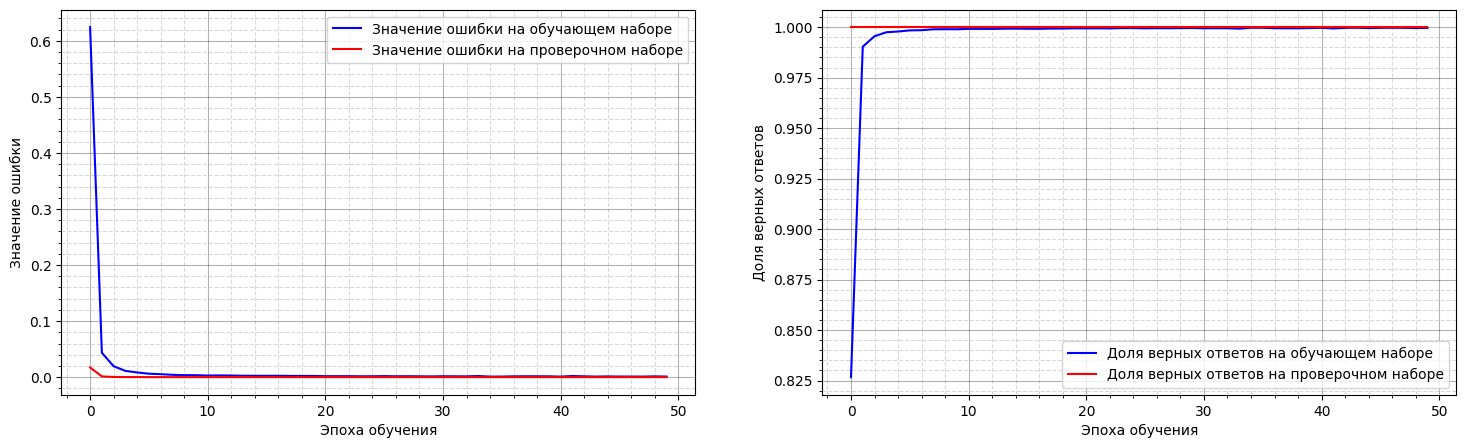

In [110]:
# Отобразим результаты на графике
printNNChart(history1)

# Оценка результатов

In [111]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

922/922 [==============================] - 1s 918us/step - loss: 1.5118e-09 - accuracy: 1.0000
Процент верных ответов на тестовых данных: 100.0 %


In [112]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
# print(f'Эпохи: {EPOCHS}')
for i in range(EPOCHS):
  # print(f'  {i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Нейронная сеть под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Нейронная сеть под номером: 0 из 50 эпох
  достигла точности: 100.0%


# Оценка предсказаний по тестовой выборке

## Оценка по все тестовой выборке

In [113]:
pred1 = model1.predict(x_test)

# У нас 23-класса Заключения:
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(len(conclusion_lst), dtype=int)
arr_false = np.zeros(len(conclusion_lst), dtype=int)

for i in range(y_test.shape[0]):
  # Получение индекса самого большого элемента
  # потому что мы имеем дело с one-hot-encoding, поэтому необходимо
  # определить элемент в массиве с максимальным значением,
  # индекс этого элемента и будет говорить о верном элементе
  #~индекс тестового элемента
  y_inx_max = np.argmax(y_test[i,:])
  #~индекс предсказанного элемента
  pred_inx_max = np.argmax(pred1[i,:])
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print(f'Результаты предсказаний по тестовой выборке ({y_test.shape[0]} - записей)')

print('Заключение:')
for i in range(len(conclusion_lst)):
  print(f'  {i}: код: {conclusion_lst[i]}')
  print(f'        верное: {arr_true[i]}')
  print(f'        неверное: {arr_false[i]}')

922/922 [==============================] - 1s 808us/step
Результаты предсказаний по тестовой выборке (29491 - записей)
Заключение:
  0: код: 111222
        верное: 818
        неверное: 0
  1: код: 111232
        верное: 819
        неверное: 0
  2: код: 111322
        верное: 1640
        неверное: 0
  3: код: 111323
        верное: 2046
        неверное: 0
  4: код: 111332
        верное: 1230
        неверное: 0
  5: код: 111333
        верное: 2866
        неверное: 0
  6: код: 111432
        верное: 2458
        неверное: 0
  7: код: 111433
        верное: 2458
        неверное: 0
  8: код: 112323
        верное: 820
        неверное: 0
  9: код: 112333
        верное: 820
        неверное: 0
  10: код: 112432
        верное: 818
        неверное: 0
  11: код: 112433
        верное: 2866
        неверное: 0
  12: код: 223111
        верное: 1640
        неверное: 0
  13: код: 323111
        верное: 1636
        неверное: 0
  14: код: 412433
        верное: 410
        неверное: 0


## Оценка предсказаний по 104-й строке тестовой выборки

In [114]:
x_row2 = x_test[104].astype(int).tolist()
print(f'x_row2: length: {len(x_row2)}: {x_row2}')

x_row2: length: 35: [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [115]:
def getXLstVector(inxStage,inxHistology,inxECOG,inxAge,inxGender,inxMolecularStatus,
                  inxPD_L1Status,inxSmokingStatus,inxContraindicationsRT,inxPatientPreference):
  '''
  Числовое кодирование X-вектора

  Args:
    inxStage...inxPatientPreference - числовые индексы из списка возможных

  Returns:
    массив числовых кодов
  '''
  #~~~~~~~~~~~~~~~~~~~~~~~~
  # print(f"#~1. 'Стадия': `{inxStage}`")
  # print(f"#~2. 'Гистология': `{inxHistology}`")
  # print(f"#~3. 'ECOG': `{inxECOG}`")
  # print(f"#~4. 'Возраст': `{inxAge}`")
  # print(f"#~5. 'Пол': `{inxGender}`")
  # print(f"#~6. 'Молекулярный статус (только для неплоскоклеточного рака)': `{inxMolecularStatus}`")
  # print(f"#~7. 'PD-L1 статус': `{inxPD_L1Status}`")
  # print(f"#~8. 'Статус курения': `{inxSmokingStatus}`")
  # print(f"#~9. 'Относительные противопоказания к ЛТ': `{inxContraindicationsRT}`")
  # print(f"#~10. 'Предпочтение пациента по ответу на терапию': `{inxPatientPreference}`")
  #~~~~~~~~~~~~~~~~~~~~~~~~
  retVal = []
  #~~~1. 'Стадия'
  retVal.append(inxStage)
  #~~~2. 'Гистология': one-hot-encoding
  ohe_arr2 = utils.to_categorical(inxHistology, 3)
  ohe_lst2 = ohe_arr2.astype(int).tolist()
  # print(f'ohe_arr2: {ohe_arr2}')
  # print(f'ohe_lst2: {ohe_lst2}')
  retVal.extend(ohe_lst2)
  #~~~3. 'ECOG'
  ohe_arr3 = utils.to_categorical(inxECOG, 3)
  ohe_lst3 = ohe_arr3.astype(int).tolist()
  retVal.extend(ohe_lst3)
  #~~~4. 'Возраст'
  retVal.append(inxAge)
  #~~~5. 'Пол'
  retVal.append(inxGender)
  #~~~6. 'Молекулярный статус (только для неплоскоклеточного рака)'
  ohe_arr6 = utils.to_categorical(inxMolecularStatus, 16)
  ohe_lst6 = ohe_arr6.astype(int).tolist()
  retVal.extend(ohe_lst6)
  #~~~7. 'PD-L1 статус'
  ohe_arr7 = utils.to_categorical(inxPD_L1Status, 4)
  ohe_lst7 = ohe_arr7.astype(int).tolist()
  retVal.extend(ohe_lst7)
  #~~~8. 'Статус курения'
  ohe_arr8 = utils.to_categorical(inxSmokingStatus, 4)
  ohe_lst8 = ohe_arr8.astype(int).tolist()
  retVal.extend(ohe_lst8)
  #~~~9. 'Относительные противопоказания к ЛТ'
  retVal.append(inxContraindicationsRT)
  #~~~10. 'Предпочтение пациента по ответу на терапию'
  retVal.append(inxPatientPreference)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  del ohe_arr2
  del ohe_lst2
  del ohe_arr3
  del ohe_lst3
  del ohe_arr6
  del ohe_lst6
  del ohe_arr7
  del ohe_lst7
  del ohe_arr8
  del ohe_lst8
  #~~~~~~~~~~~~~~~~~~~~~~~~
  return retVal

In [116]:
#~1. 'Стадия': 0|IIIаI
inxStage = 0
#~2. 'Гистология': 1|неплоскоклеточный
inxHistology = 1
#~3. 'ECOG': 2|3+
inxECOG = 2
#~4. 'Возраст': 0|до 70
inxAge = 0
#~5. 'Пол': 1|женский
inxGender = 1
#~6. 'Молекулярный статус (только для неплоскоклеточного рака)': 1|нет мутаций
inxMolecularStatus = 1
#~7. 'PD-L1 статус': 0|не исследовался
inxPD_L1Status = 0
#~8. 'Статус курения': 0|в настоящее время
inxSmokingStatus = 0
#~9. 'Относительные противопоказания к ЛТ': 0|нет
inxContraindicationsRT = 0
#~10. 'Предпочтение пациента по ответу на терапию': 0|результативность лечения
inxPatientPreference = 0

x_row_lst = getXLstVector(inxStage,inxHistology,inxECOG,inxAge,inxGender,inxMolecularStatus,
                          inxPD_L1Status,inxSmokingStatus,inxContraindicationsRT,inxPatientPreference)

print(f'x_row_lst: length: {len(x_row_lst)}: {x_row_lst}')

x_row_lst: length: 35: [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [117]:
x_row_arr = np.array(x_row_lst, dtype=np.float32).reshape(1, len(x_row_lst))
print(x_row_arr)

[[0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [118]:
pred2 = model1.predict(x_row_arr)

1/1 [==============================] - 0s 18ms/step


In [119]:
print(pred2)
print('pred2:')
print(f'  тип: {type(pred2)}')
print(f'  тип данных: {pred2.dtype}')
print(f'  количество осей: {pred2.ndim}')
print(f'  форма массива: {pred2.shape}')
print(f'  количество значений: {pred2.size}')

[[4.6382073e-31 0.0000000e+00 2.4733487e-26 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 4.9730770e-29 1.0000000e+00 3.8077228e-17 6.9605516e-36
  7.4333200e-25 1.0959512e-35 0.0000000e+00 1.6024211e-15 1.0321922e-30
  0.0000000e+00 2.2923584e-32 0.0000000e+00]]
pred2:
  тип: <class 'numpy.ndarray'>
  тип данных: float32
  количество осей: 2
  форма массива: (1, 23)
  количество значений: 23


In [120]:
pred2_inx_max = np.argmax(pred2[0,:])
print(f'pred2_inx_max: {pred2_inx_max}')

pred2_inx_max: 12


In [121]:
def reverse_conclusion12(num):
  '''
  Реверсирование кода заключения и перевод чисел в слова

  Args:
    num - числовой код заключения

  Returns:
    список значений
  '''

  retVal = []

  #~~~~~~~~~~~~~~~~~~~~~~~~
  digits = []
  while num > 0:
    digits.append(num % 10)
    num //= 10
  print(f'digits: len: {len(digits)}: {digits}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~~~ 11 - L1 - 'Ответ эксперта (Лактионов)'
  retVal.append(getReverseExpertRecommendationCode12(digits[0]))
  #~~~ 12 - L1 - 'Вариант ХТ'
  retVal.append(getReverseChemotherapyVariantCode12(digits[1]))
  #~~~ 13 - L1 - 'Альтернативный выбор ХТ (как компонента ХЛТ)'
  retVal.append(getReverseAlternativeChemotherapyVariantCode12(digits[2]))
  #~~~ 14 - L1 - 'Поставьте галочку, если уверены на 100%'
  #~~~ 15 - L1 - 'Если 75%'
  #~~~ 16 - L1 - 'Если 50%'
  retVal.append(getReverseConfidence1007550Code(digits[3]))
  #~~~ 17 - L1 - 'Альтернатива, если 50% - обязательно'
  retVal.append(getReverseAlternativeTherapy50Code12(digits[4]))
  #~~~ 18 - L1 - 'Комментарий'
  retVal.append(getReverseCommentCode12(digits[5]))

  return retVal

In [122]:
conclusion_code = conclusion_lst[pred2_inx_max]
print(f'conclusion_code: {conclusion_code}')

rev_conclusion_lst = reverse_conclusion12(conclusion_code)
print(f'rev_conclusion_lst: len: {len(rev_conclusion_lst)}: {rev_conclusion_lst}')

conclusion_code: 223111
digits: len: 6: [1, 1, 1, 3, 2, 2]
rev_conclusion_lst: len: 6: ['симптоматическая терапия', '0', '0', 'уверенность 50%', 'Лучевая терапия в монорежиме', 'Большая вероятность инкурабельности больного.Детально оценить общесоматический статус для решения вопроса о возможности проведения монохимиотерапии или проведение ЛТ в монорежиме']


# Сохранение модели

In [123]:
# Определение пути к папке на Google Drive
# model_path = '/content/drive/MyDrive/Stazhirovka2'
# Определение пути к файлу модели
model_path = 'c:/LungCancer_AIConsultant/data_in/model2100/model21001.h5'
print(f"model_path: '{model_path}'")

model_path: 'c:/LungCancer_AIConsultant/data_in/model2100/model21001.h5'


In [124]:
# Сохранение модели с весами в файл
model1.save(model_path)